In [10]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [3]:
# Mac
path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [12]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [13]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [14]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [15]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<?, ?it/s]


In [16]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [17]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

In [18]:
import numba as nb
from superflexpy.framework.element import ODEsElement
from copy import deepcopy
import numba as nb
from superflexpy.framework.element import ODEsElement
from copy import deepcopy

class CustomUnsaturatedReservoir(UnsaturatedReservoir):
    """
    This class implements the UnsaturatedReservoir of HBV.
    """

    def __init__(self, parameters, states, approximation, id):
        
        """
        This is the initializer of the class UnsaturatedReservoir.

        Parameters
        ----------
        parameters : dict
            Parameters of the element. The keys must be:
            'Smax' : maximum reservoir storage
            'Ce' : Potential evapotranspiration multiplier
            'm' : Smoothing factor for evapotranspiration
            'beta' : Exponent in the relation for the streamflow
        states : dict
            Initial state of the element. The keys must be:
            - 'S0' : initial storage of the reservoir.
        approximation : superflexpy.utils.numerical_approximation.NumericalApproximator
            Numerial method used to approximate the differential equation
        id : str
            Itentifier of the element. All the elements of the framework must
            have an id.
        """

        ODEsElement.__init__(self, parameters=parameters, states=states, approximation=approximation, id=id)

        self._fluxes_python = [self._fluxes_function_python]

        if approximation.architecture == "numba":
            self._fluxes = [self._fluxes_function_numba]
        elif approximation.architecture == "python":
            self._fluxes = [self._fluxes_function_python]


    # METHODS FOR THE USER

    def set_input(self, input):
        """
        Set the input of the element.

        Parameters
        ----------
        input : list(numpy.ndarray)
            List containing the input fluxes of the element. It contains 2
            fluxes:
            1. Rainfall
            2. PET
        """

        self.input = {"P": input[0], "PET": input[1]}

    def get_output(self, solve=True):
        """
        This method solves the differential equation governing the routing
        store.

        Returns
        -------
        list(numpy.ndarray)
            Output fluxes in the following order:
            1. Streamflow (Q)
        """

        if solve:
            self._solver_states = [self._states[self._prefix_states + "S0"]]

            self._solve_differential_equation()

            # Update the state
            self.set_states({self._prefix_states + "S0": self.state_array[-1, 0]})

        fluxes = self._num_app.get_fluxes(
            fluxes=self._fluxes_python,
            S=self.state_array,
            S0=self._solver_states,
            dt=self._dt,
            **self.input,
            **{k[len(self._prefix_parameters) :]: self._parameters[k] for k in self._parameters},
        )

        return [-fluxes[0][2]]

    def get_AET(self):
        """
        This method calculates the actual evapotranspiration

        Returns
        -------
        numpy.ndarray
            Array of actual evapotranspiration
        """

        try:
            S = self.state_array
        except AttributeError:
            message = "{}get_aet method has to be run after running ".format(self._error_message)
            message += "the model using the method get_output"
            raise AttributeError(message)

        fluxes = self._num_app.get_fluxes(
            fluxes=self._fluxes_python,
            S=S,
            S0=self._solver_states,
            dt=self._dt,
            **self.input,
            **{k[len(self._prefix_parameters) :]: self._parameters[k] for k in self._parameters},
        )

        return [-fluxes[0][1]]

    # PROTECTED METHODS

    @staticmethod
    def _fluxes_function_python(S, S0, ind, P, Csmax, Ce, m, bacon, beta, PET, dt):
        # TODO: handle time variable parameters (Smax) -> overflow
        Smax = Csmax * bacon

        if ind is None:
            return (
                [
                    P,
                    -Ce * PET * ((S / Smax) * (1 + m)) / ((S / Smax) + m),
                    -P * (S / Smax) ** beta,
                ],
                0.0,
                S0 + P * dt,
            )
        else:
            Smax[ind] = Csmax[ind] * bacon[ind]

            return (
                [
                    P[ind],
                    -Ce[ind] * PET[ind] * ((S / Smax[ind]) * (1 + m[ind])) / ((S / Smax[ind]) + m[ind]),
                    -P[ind] * (S / Smax[ind]) ** beta[ind],
                ],
                0.0,
                S0 + P[ind] * dt[ind],
                [
                    0.0,
                    -(Ce[ind] * PET[ind] * m[ind] * (m[ind] + 1) * Smax[ind]) / ((S + m[ind] * Smax[ind]) ** 2),
                    -(P[ind] * beta[ind] / Smax[ind]) * (S / Smax[ind]) ** (beta[ind] - 1),
                ],
            )

    @staticmethod
    @nb.jit(
        "Tuple((UniTuple(f8, 3), f8, f8,UniTuple(f8, 3)))"
        "(optional(f8), f8, i4, f8[:], f8[:], f8[:], f8[:], f8[:], f8[:], f8[:], f8[:])",
        nopython=True,
    )
    def _fluxes_function_numba(S, S0, ind, P, Csmax, Ce, m, bacon, beta, PET, dt):
        # TODO: handle time variable parameters (Smax) -> overflow
        Smax = Csmax * bacon
        
        return (
            (
                P[ind],
                -Ce[ind] * PET[ind] * ((S / Smax[ind]) * (1 + m[ind])) / ((S / Smax[ind]) + m[ind]),
                -P[ind] * (S / Smax[ind]) ** beta[ind],
            ),
            0.0,
            S0 + P[ind] * dt[ind],
            (
                0.0,
                -(Ce[ind] * PET[ind] * m[ind] * (m[ind] + 1) * Smax[ind]) / ((S + m[ind] * Smax[ind]) ** 2),
                -(P[ind] * beta[ind] / Smax[ind]) * (S / Smax[ind]) ** (beta[ind] - 1),
            ),
        )

In [19]:
def assign_parameter_values(parameters_name_model, parameter_names, parameters):
    """
    Assigns values from `parameters` to `parameters_name_model` where a match exists in `parameter_names`,
    but keeps any parameters that have three segments (`X_Y_Z`) unchanged.

    Args:
        parameters_name_model (list): List of full parameter names (e.g., "general_slow_k").
        parameter_names (list): List of unique parameter names (e.g., "slow_k", "high_slow_k").
        parameters (list): List of values corresponding to `parameter_names`.

    Returns:
        dict: Dictionary {parameter_name_model: assigned_value}, where:
            - `X_Y` parameters are updated from `parameter_names`.
            - `X_Y_Z` parameters are kept unchanged.
    """
    # Create a dictionary mapping parameter_names to their corresponding values
    param_value_dict = {param_name: value for param_name, value in zip(parameter_names, parameters)}

    # Build the output dictionary
    filtered_parameters = {}

    for param_name in parameters_name_model:
        parts = param_name.split("_")  # Split the name to check structure
        base_name = "_".join(parts[-2:])  # Extract last two parts (X_Y)
        
        if base_name in param_value_dict:  # If X_Y is in parameter_names
            filtered_parameters[param_name] = param_value_dict[base_name]
        elif param_name in parameter_names:  # Direct match in parameter_names (X_Y)
            filtered_parameters[param_name] = param_value_dict[param_name]
    
    return filtered_parameters  # Return dictionary of matched parameters


class spotpy_model(object):

    def __init__(self, model, catchments, dt, observations, parameters, parameter_names, parameter_names_model, output_index, warm_up=365):

        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            model (Network): SuperflexPy network containing multiple nodes.
            catchments (list): List of Node objects.
            inputs (dict): Dictionary with inputs for each node.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._model = model  # The SuperflexPy network
        self._catchments = catchments  # List of catchments
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names
        self._parameter_names_model = parameter_names_model  # Store full parameter names

        # Store inputs and observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the entire network using the same parameter set and collects per-node outputs."""

        # Convert parameter list into a dictionary
        #named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
        
        # Check if parameters have changed (avoid unnecessary computations)
        if not hasattr(self, "_cached_params") or not np.array_equal(self._cached_params, parameters):
            self._cached_params = np.array(parameters)  # Store the current parameters
            named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
            self._model.set_parameters(named_parameters)  # Apply shared parameters

        # Apply shared parameters to the whole network (this is due to the way we set Csumax)
        for key in model._content_pointer.keys():
            i = model._content_pointer[key] 
            self._model._content[i].set_parameters(named_parameters)
        #self._model.set_parameters(named_parameters)

        # Set timestep and reset the network
        self._model.set_timestep(self._dt)
        self._model.reset_states()

        # Run the full network
        output = self._model.get_output()  # Get outputs for all nodes

        # Return outputs as a list (one per node)
        return [output[cat.id][self._output_index] for cat in self._catchments]

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for sim, cat in zip(simulation, self._catchments):
            node_id = cat.id
            obs = evaluation[node_id]

            # Apply warm-up period
            sim = sim[self._warm_up + 1:]
            obs = obs[self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error

In [20]:
data_text = """"
high_snow_k,3.0543392206359528
high_unsaturated_Smax,152.24836010494946
high_unsaturated_Ce,1.0201279161858614
high_unsaturated_beta,0.8113683893845915
high_slowhigh_k,6.440000000017071e-05
general_snow_k,3.0543392206359528
general_unsaturated_Smax,152.24836010494946
general_unsaturated_Ce,1.0201279161858614
general_unsaturated_beta,0.8113683893845915
general_lowersplitter_splitpar,0.5010000000005239
general_slow_k,0.08185382689099417
general_lag-fun_lag-time,2.9579108997419956
general_fast_k,0.19437734859985495
low_snow_k,3.0543392206359528
low_unsaturated_Smax,152.24836010494946
low_unsaturated_Ce,1.0201279161858614
low_unsaturated_beta,0.8113683893845915
low_fast_k,0.004677629904959929
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_1[key] = float(value)
    else:
        1+1

In [21]:
data_text = """"
high_snow_k,2.930483638554881
high_unsaturated_Smax,225.18897907157685
high_unsaturated_Ce,1.0536277651792032
high_unsaturated_beta,0.7300765922948531
high_slowhigh_k,0.00011700000000005459
general_snow_k,2.930483638554881
general_unsaturated_Smax,225.18897907157685
general_unsaturated_Ce,1.0536277651792032
general_unsaturated_beta,0.7300765922948531
general_lowersplitter_splitpar,0.5000000000002116
general_slow_k,0.08714500573429074
general_lag-fun_lag-time,3.1148512951889744
general_fast_k,0.12911429342224337
low_snow_k,2.930483638554881
low_unsaturated_Smax,225.18897907157685
low_unsaturated_Ce,1.0536277651792032
low_unsaturated_beta,0.7300765922948531
low_fast_k,0.0038291109489411277
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_2 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_2[key] = float(value)
    else:
        1+1

In [22]:
data_text = """"
high_snow_k,1.843545894902258
high_unsaturated_Smax,122.71792975383084
high_unsaturated_Ce,1.3680658998241941
high_unsaturated_beta,0.8488477126426069
high_slowhigh_k,1.870921744063965e-05
general_snow_k,1.843545894902258
general_unsaturated_Smax,122.71792975383084
general_unsaturated_Ce,1.3680658998241941
general_unsaturated_beta,0.8488477126426069
general_lowersplitter_splitpar,0.5000242296469859
general_slow_k,0.09950731141761572
general_lag-fun_lag-time,2.999852241580967
general_fast_k,0.17984776225475138
low_snow_k,1.843545894902258
low_unsaturated_Smax,122.71792975383084
low_unsaturated_Ce,1.3680658998241941
low_unsaturated_beta,0.8488477126426069
low_fast_k,0.0033908514824536463
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_1_8801[key] = float(value)
    else:
        1+1


In [23]:
data_text = """"
high_snow_k,1.574877751167112
high_unsaturated_Smax,189.7900828022733
high_unsaturated_Ce,1.235114881285675
high_unsaturated_beta,0.7873304606057695
high_slowhigh_k,3.19000000001076e-05
general_snow_k,1.574877751167112
general_unsaturated_Smax,189.7900828022733
general_unsaturated_Ce,1.235114881285675
general_unsaturated_beta,0.7873304606057695
general_lowersplitter_splitpar,0.5000000000050095
general_slow_k,0.09568628655152381
general_lag-fun_lag-time,3.1321824521302313
general_fast_k,0.07772516534893224
low_snow_k,1.574877751167112
low_unsaturated_Smax,189.7900828022733
low_unsaturated_Ce,1.235114881285675
low_unsaturated_beta,0.7873304606057695
low_fast_k,0.0033233384382156776
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_2_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_2_8801[key] = float(value)
    else:
        1+1


In [24]:
data_text = """"
high_snow_k,3.0773161717474986
high_unsaturated_Csmax,0.5080092760200876
high_unsaturated_Ce,1.019118258680726
high_unsaturated_beta,0.7921739483743102
high_slowhigh_k,6.10008776565738e-05
general_snow_k,3.0773161717474986
general_unsaturated_Csmax,0.5080092760200876
general_unsaturated_Ce,1.019118258680726
general_unsaturated_beta,0.7921739483743102
general_lowersplitter_splitpar,0.500035551548686
general_slow_k,0.08948126331670521
general_lag-fun_lag-time,2.9751926331408343
general_fast_k,0.19284203607196362
low_snow_k,3.0773161717474986
low_unsaturated_Csmax,0.5080092760200876
low_unsaturated_Ce,1.019118258680726
low_unsaturated_beta,0.7921739483743102
low_fast_k,0.004420779347462569
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_WD_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_WD_1[key] = float(value)
    else:
        1+1

In [25]:
data_text = """"
high_snow_k,2.8221657355390706
high_unsaturated_Csmax,0.8054733499168569
high_unsaturated_Ce,1.1023148588376785
high_unsaturated_beta,0.64258728037343
high_slowhigh_k,0.00017800000511292358
general_snow_k,2.8221657355390706
general_unsaturated_Csmax,0.8054733499168569
general_unsaturated_Ce,1.1023148588376785
general_unsaturated_beta,0.64258728037343
general_lowersplitter_splitpar,0.5000000638866942
general_slow_k,0.08301542777276402
general_lag-fun_lag-time,3.1024459531473694
general_fast_k,0.13951761727238982
low_snow_k,2.8221657355390706
low_unsaturated_Csmax,0.8054733499168569
low_unsaturated_Ce,1.1023148588376785
low_unsaturated_beta,0.64258728037343
low_fast_k,0.0034104149100781063
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_WD_2 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_WD_2[key] = float(value)
    else:
        1+1

In [26]:
data_text = """"
high_snow_k,3.0399026786341596
high_unsaturated_Csmax,1.286123261996777
high_unsaturated_Ce,0.9887057433311104
high_unsaturated_beta,0.9256778391887183
high_slowhigh_k,4.340000187429921e-05
general_snow_k,3.0399026786341596
general_unsaturated_Csmax,1.286123261996777
general_unsaturated_Ce,0.9887057433311104
general_unsaturated_beta,0.9256778391887183
general_lowersplitter_splitpar,0.5020000034160002
general_slow_k,0.08831162343005422
general_lag-fun_lag-time,2.9648175525267315
general_fast_k,0.19453931855369794
low_snow_k,3.0399026786341596
low_unsaturated_Csmax,1.286123261996777
low_unsaturated_Ce,0.9887057433311104
low_unsaturated_beta,0.9256778391887183
low_fast_k,0.004401355898218228
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_RD_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_RD_1[key] = float(value)
    else:
        1+1

In [27]:
data_text = """"
high_snow_k,2.776300412985458
high_unsaturated_Csmax,2.635396895631869
high_unsaturated_Ce,1.1293026376759365
high_unsaturated_beta,0.6040057033860092
high_slowhigh_k,0.0003110000000092663
general_snow_k,2.776300412985458
general_unsaturated_Csmax,2.635396895631869
general_unsaturated_Ce,1.1293026376759365
general_unsaturated_beta,0.6040057033860092
general_lowersplitter_splitpar,0.5000000003390411
general_slow_k,0.07366216002138976
general_lag-fun_lag-time,3.1216804917038465
general_fast_k,0.15031766744323977
low_snow_k,2.776300412985458
low_unsaturated_Csmax,2.635396895631869
low_unsaturated_Ce,1.1293026376759365
low_unsaturated_beta,0.6040057033860092
low_fast_k,0.00343123229167969
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_RD_2 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_RD_2[key] = float(value)
    else:
        1+1

In [28]:
data_text = """"
high_snow_k,1.8040641294641064
high_unsaturated_Csmax,2.6640061707149743
high_unsaturated_Ce,1.4749075939730816
high_unsaturated_beta,0.485009718656779
high_slowhigh_k,0.00011900000017373911
general_snow_k,1.8040641294641064
general_unsaturated_Csmax,2.6640061707149743
general_unsaturated_Ce,1.4749075939730816
general_unsaturated_beta,0.485009718656779
general_lowersplitter_splitpar,0.500000002371989
general_slow_k,0.09711863373815482
general_lag-fun_lag-time,3.0000000160103513
general_fast_k,0.17529022719878048
low_snow_k,1.8040641294641064
low_unsaturated_Csmax,2.6640061707149743
low_unsaturated_Ce,1.4749075939730816
low_unsaturated_beta,0.485009718656779
low_fast_k,0.0037241237922301254
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_RD_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_RD_1_8801[key] = float(value)
    else:
        1+1

In [29]:
data_text = """"
high_snow_k,1.5819431287641863
high_unsaturated_Csmax,2.452466839893684
high_unsaturated_Ce,1.2943512571242457
high_unsaturated_beta,0.6076407294199608
high_slowhigh_k,9.070000010781885e-05
general_snow_k,1.5819431287641863
general_unsaturated_Csmax,2.452466839893684
general_unsaturated_Ce,1.2943512571242457
general_unsaturated_beta,0.6076407294199608
general_lowersplitter_splitpar,0.5000000009441838
general_slow_k,0.09660440531992417
general_lag-fun_lag-time,3.086214261076472
general_fast_k,0.07457433366365214
low_snow_k,1.5819431287641863
low_unsaturated_Csmax,2.452466839893684
low_unsaturated_Ce,1.2943512571242457
low_unsaturated_beta,0.6076407294199608
low_fast_k,0.003229097142452077
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_RD_2_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_RD_2_8801[key] = float(value)
    else:
        1+1

In [30]:
data_text = """"
high_snow_k,1.8222329781479907
high_unsaturated_Csmax,1.0808682476079423
high_unsaturated_Ce,1.4133681126085482
high_unsaturated_beta,0.46497580541205585
high_slowhigh_k,0.00017400005347218512
general_snow_k,1.8222329781479907
general_unsaturated_Csmax,1.0808682476079423
general_unsaturated_Ce,1.4133681126085482
general_unsaturated_beta,0.46497580541205585
general_lowersplitter_splitpar,0.5000000162115795
general_slow_k,0.09304600011320718
general_lag-fun_lag-time,2.9999998496805245
general_fast_k,0.17750053228499219
low_snow_k,1.8222329781479907
low_unsaturated_Csmax,1.0808682476079423
low_unsaturated_Ce,1.4133681126085482
low_unsaturated_beta,0.46497580541205585
low_fast_k,0.0037096103188472103
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_WD_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_WD_1_8801[key] = float(value)
    else:
        1+1

In [31]:
data_text = """"
high_snow_k,1.566485388385493
high_unsaturated_Csmax,0.5050005352475829
high_unsaturated_Ce,1.169621267116
high_unsaturated_beta,0.9778568359782094
high_slowhigh_k,1.2000005252819274e-05
general_snow_k,1.566485388385493
general_unsaturated_Csmax,0.5050005352475829
general_unsaturated_Ce,1.169621267116
general_unsaturated_beta,0.9778568359782094
general_lowersplitter_splitpar,0.5010000176402598
general_slow_k,0.09969324908627121
general_lag-fun_lag-time,3.1609039434204256
general_fast_k,0.08545520413103914
low_snow_k,1.566485388385493
low_unsaturated_Csmax,0.5050005352475829
low_unsaturated_Ce,1.169621267116
low_unsaturated_beta,0.9778568359782094
low_fast_k,0.0027678786426783204
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_WD_2_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_WD_2_8801[key] = float(value)
    else:
        1+1

In [128]:
    path_inputs = '../data/models/input/subset_2001_2015'

    inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
    observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
    areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
    perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
    perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
    perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
    quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
    rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
    waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

    perm_areas_model = perm_areas
    best_params_dict_model = best_params_dict_model_r_WD_1
    waterdeficit_mean_model = waterdeficit_mean

In [129]:
best_params_dict_model

{'high_snow_k': 3.0773161717474986,
 'high_unsaturated_Csmax': 0.5080092760200876,
 'high_unsaturated_Ce': 1.019118258680726,
 'high_unsaturated_beta': 0.7921739483743102,
 'high_slowhigh_k': 6.10008776565738e-05,
 'general_snow_k': 3.0773161717474986,
 'general_unsaturated_Csmax': 0.5080092760200876,
 'general_unsaturated_Ce': 1.019118258680726,
 'general_unsaturated_beta': 0.7921739483743102,
 'general_lowersplitter_splitpar': 0.500035551548686,
 'general_slow_k': 0.08948126331670521,
 'general_lag-fun_lag-time': 2.9751926331408343,
 'general_fast_k': 0.19284203607196362,
 'low_snow_k': 3.0773161717474986,
 'low_unsaturated_Csmax': 0.5080092760200876,
 'low_unsaturated_Ce': 1.019118258680726,
 'low_unsaturated_beta': 0.7921739483743102,
 'low_fast_k': 0.004420779347462569}

In [34]:
    catchments_ids = estreams_attributes_clipped_filters.index.tolist()
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

In [145]:

    

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes

    for cat_id in catchments_ids:

        unsaturated = CustomUnsaturatedReservoir(
            parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': waterdeficit_mean_model[cat_id].round(1)},
            states={'S0': waterdeficit_mean_model[cat_id].round(1)*0.5*0.1},
            approximation=num_app,
            id='unsaturated')


        general = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [lower_splitter],
                [slow, lag_fun],
                [lower_transparent, fast],
                [lower_junction],
            ],
            id='general'
        )

        low = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [fast],
            ],
            id='low'
        )

        high = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [slowhigh],
            ],
            id='high'
        )

        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        
        node.set_input(inputs[cat_id])  # Correct way to set inputs
        
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        #globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )


    model.reset_states()

    model.set_timestep(1.0)

    # Apply shared parameters to the whole network (this is due to the way we set Csumax)
    for key in model._content_pointer.keys():
        i = model._content_pointer[key] 
        model._content[i].set_parameters(best_params_dict_model)

    #model.set_parameters(best_params_dict_model)

    #hyd_mod.reset_states()
    #output = model.get_output()



In [146]:
model.get_states()

{'BEWA0066_high_snow_S0': 0.0,
 'BEWA0066_high_unsaturated_S0': 13.200000000000001,
 'BEWA0066_high_slowhigh_S0': 0.0,
 'BEWA0066_general_snow_S0': 0.0,
 'BEWA0066_general_unsaturated_S0': 13.200000000000001,
 'BEWA0066_general_slow_S0': 0.0,
 'BEWA0066_general_lag-fun_lag': None,
 'BEWA0066_general_fast_S0': 0.0,
 'BEWA0066_low_snow_S0': 0.0,
 'BEWA0066_low_unsaturated_S0': 13.200000000000001,
 'BEWA0066_low_fast_S0': 0.0,
 'BEWA0067_high_snow_S0': 0.0,
 'BEWA0067_high_unsaturated_S0': 11.82,
 'BEWA0067_high_slowhigh_S0': 0.0,
 'BEWA0067_general_snow_S0': 0.0,
 'BEWA0067_general_unsaturated_S0': 11.82,
 'BEWA0067_general_slow_S0': 0.0,
 'BEWA0067_general_lag-fun_lag': None,
 'BEWA0067_general_fast_S0': 0.0,
 'BEWA0067_low_snow_S0': 0.0,
 'BEWA0067_low_unsaturated_S0': 11.82,
 'BEWA0067_low_fast_S0': 0.0,
 'BEWA0087_high_snow_S0': 0.0,
 'BEWA0087_high_unsaturated_S0': 14.435,
 'BEWA0087_high_slowhigh_S0': 0.0,
 'BEWA0087_general_snow_S0': 0.0,
 'BEWA0087_general_unsaturated_S0': 14.435

In [160]:
for key in model._content_pointer.keys():
        i = model._content_pointer[key] 
        print(key, i)

BEWA0066 0
BEWA0067 1
BEWA0087 2
BEWA0106 3
BEWA0107 4
BEWA0119 5
DEBU1956 6
DEBU1957 7
DEBU1958 8
DEBU1959 9
DERP2003 10
DERP2004 11
DERP2005 12
DERP2006 13
DERP2007 14
DERP2008 15
DERP2010 16
DERP2011 17
DERP2013 18
DERP2014 19
DERP2015 20
DERP2016 21
DERP2017 22
DERP2018 23
DERP2021 24
DERP2022 25
DERP2023 26
DERP2024 27
DERP2027 28
DERP2028 29
DERP2029 30
DERP2030 31
DERP2031 32
DERP2033 33
DERP2036 34
FR000124 35
FR000125 36
FR000128 37
FR000132 38
FR000137 39
FR000138 40
FR000140 41
FR000142 42
FR000144 43
FR000153 44
FR000154 45
FR000156 46
FR000159 47
FR000169 48
FR000171 49
FR000174 50
FR000183 51
FR000184 52
FR000185 53
FR000190 54
FR000200 55
FR000201 56
FR003234 57
FR003236 58
FR003237 59
FR003239 60
FR003241 61
FR003246 62
FR003249 63
FR003250 64
FR003251 65
FR003252 66
FR003253 67
FR003254 68
FR003256 69
FR003257 70
FR003259 71
FR003261 72
FR003262 73
FR003265 74
FR003266 75
FR003267 76
FR003268 77
FR003271 78
FR003272 79
FR003274 80
FR003275 81
FR003280 82
FR003283 83
FR

In [56]:
model._content[0].get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 3.0773161717474986,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 0.5080092760200876,
 'high_unsaturated_Ce': 1.019118258680726,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 0.7921739483743102,
 'high_unsaturated_bacon': 264.0,
 'high_slowhigh_k': 6.10008776565738e-05,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 3.0773161717474986,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 0.5080092760200876,
 'general_unsaturated_Ce': 1.019118258680726,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 0.7921739483743102,
 'general_unsaturated_bacon': 264.0,
 'general_lowersplitter_splitpar': 0.500035551548686,
 'general_slow_k': 0.08948126331670521,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 2.9751926331408343,
 'general_fast_k': 0.19284203607196362,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 3.0773161717474986,
 'low_snow_m': 2.0,
 'low_unsaturated_Csmax': 0.508009

In [51]:

    path_inputs = '../data/models/input/subset_1988_2001'
    waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

    perm_areas_model = perm_areas
    best_params_dict_model = best_params_dict_model_r_WD_1
    waterdeficit_mean_model = waterdeficit_mean

In [130]:
average = sum(waterdeficit_mean_model.values()) / len(waterdeficit_mean_model)
print("Average water deficit:", average)

Average water deficit: 318.4467105263158


In [50]:
average = sum(waterdeficit_mean_model.values()) / len(waterdeficit_mean_model)
print("Average water deficit:", average)


Average water deficit: 318.4467105263158


In [32]:
waterdeficit_mean_model["DERP2003"]

320.7

In [147]:
outputDERP2003 = model._content[0].get_output()
outputDERP2003

[array([0.0049748 , 0.13943388, 0.16667132, ..., 1.110964  , 0.97933253,
        0.8700495 ])]

In [148]:
model.get_states()

{'BEWA0066_high_snow_S0': 0.0,
 'BEWA0066_high_unsaturated_S0': 38.53878705330178,
 'BEWA0066_high_slowhigh_S0': 115.65324702329255,
 'BEWA0066_general_snow_S0': 0.0,
 'BEWA0066_general_unsaturated_S0': 38.53878705330178,
 'BEWA0066_general_slow_S0': 6.1725916542894605,
 'BEWA0066_general_lag-fun_lag': [array([0., 0., 0.])],
 'BEWA0066_general_fast_S0': 0.8579370617333913,
 'BEWA0066_low_snow_S0': 0.0,
 'BEWA0066_low_unsaturated_S0': 38.53878705330178,
 'BEWA0066_low_fast_S0': 14.087894566510917,
 'BEWA0067_high_snow_S0': 0.0,
 'BEWA0067_high_unsaturated_S0': 11.82,
 'BEWA0067_high_slowhigh_S0': 0.0,
 'BEWA0067_general_snow_S0': 0.0,
 'BEWA0067_general_unsaturated_S0': 11.82,
 'BEWA0067_general_slow_S0': 0.0,
 'BEWA0067_general_lag-fun_lag': None,
 'BEWA0067_general_fast_S0': 0.0,
 'BEWA0067_low_snow_S0': 0.0,
 'BEWA0067_low_unsaturated_S0': 11.82,
 'BEWA0067_low_fast_S0': 0.0,
 'BEWA0087_high_snow_S0': 0.0,
 'BEWA0087_high_unsaturated_S0': 14.435,
 'BEWA0087_high_slowhigh_S0': 0.0,
 '

In [131]:
outputDERP2003 = model._content[0].get_output()
outputDERP2003

[array([0.0049748 , 0.13943388, 0.16667132, ..., 1.110964  , 0.97933253,
        0.8700495 ])]

In [63]:
waterdeficit_mean_model["BEWA0066"]*0.5080092760200876

134.11444886930312

In [162]:
outputDERP2003

[array([0.00373598, 0.11619837, 0.13977813, ..., 1.110964  , 0.97933253,
        0.8700495 ])]

In [114]:
best_params_dict_model_r_1

{'high_snow_k': 3.0543392206359528,
 'high_unsaturated_Smax': 152.24836010494946,
 'high_unsaturated_Ce': 1.0201279161858614,
 'high_unsaturated_beta': 0.8113683893845915,
 'high_slowhigh_k': 6.440000000017071e-05,
 'general_snow_k': 3.0543392206359528,
 'general_unsaturated_Smax': 152.24836010494946,
 'general_unsaturated_Ce': 1.0201279161858614,
 'general_unsaturated_beta': 0.8113683893845915,
 'general_lowersplitter_splitpar': 0.5010000000005239,
 'general_slow_k': 0.08185382689099417,
 'general_lag-fun_lag-time': 2.9579108997419956,
 'general_fast_k': 0.19437734859985495,
 'low_snow_k': 3.0543392206359528,
 'low_unsaturated_Smax': 152.24836010494946,
 'low_unsaturated_Ce': 1.0201279161858614,
 'low_unsaturated_beta': 0.8113683893845915,
 'low_fast_k': 0.004677629904959929}

In [ ]:

    perm_areas_model = perm_areas
    best_params_dict_model = best_params_dict_model_r_1
    #waterdeficit_mean_model = waterdeficit_mean

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    node = []

    unsaturated_general = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 15.0},
    approximation=num_app,
    id='unsaturated'
    )
    
    general1 = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general')

    low1 = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low')

    high1 = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high')

    for cat_id in catchments_ids:
        node = Node(
            units=[high1, general1, low1],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        #globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model2 = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology
        
    )

    model2.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs

    model2.set_timestep(1.0)
    model2.set_parameters(best_params_dict_model)
    outputr1DERP2003 = model2._content[0].get_output()
    output2 = model2._content[1].get_output()

    #output = model.get_output()

In [219]:
model2.get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 3.0543392206359528,
 'high_snow_m': 2.0,
 'high_unsaturatedhigh_Smax': 150.0,
 'high_unsaturatedhigh_Ce': 1.0,
 'high_unsaturatedhigh_m': 0.01,
 'high_unsaturatedhigh_beta': 2.0,
 'high_slowhigh_k': 6.440000000017071e-05,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 3.0543392206359528,
 'general_snow_m': 2.0,
 'general_unsaturatedgeneral_Smax': 150.0,
 'general_unsaturatedgeneral_Ce': 1.0,
 'general_unsaturatedgeneral_m': 0.01,
 'general_unsaturatedgeneral_beta': 2.0,
 'general_lowersplitter_splitpar': 0.5010000000005239,
 'general_slow_k': 0.08185382689099417,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 2.9579108997419956,
 'general_fast_k': 0.19437734859985495,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 3.0543392206359528,
 'low_snow_m': 2.0,
 'low_unsaturatedlow_Smax': 150.0,
 'low_unsaturatedlow_Ce': 1.0,
 'low_unsaturatedlow_m': 0.01,
 'low_unsaturatedlow_beta': 2.0,
 'low_fast_k': 

In [224]:
model2._content[0].get_internal(id='BEWA0066_general', attribute='state_array')


KeyError: 'general'

In [210]:
model2._content[1].get_internal(id='BEWA0067_unsaturated', attribute='state_array')


array([[18.69947946],
       [31.35043746],
       [31.39946957],
       ...,
       [50.88338722],
       [49.24432221],
       [47.71666124]])

In [216]:
def list_all_internal_ids(node):
    ids = []
    for unit in node._content:
        try:
            ids += unit.get_internal_ids()
        except AttributeError:
            # fallback to elements inside the unit
            for comp in unit._content.values():
                try:
                    ids += comp.get_internal_ids()
                except Exception:
                    continue
    return ids

list_all_internal_ids(model2._content[0])



[]

In [127]:
outputr1DERP2003

[array([0.00462249, 0.12846382, 0.15360701, ..., 1.0442637 , 0.92093381,
        0.81849902])]

In [116]:
model2._content[0].get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 3.0543392206359528,
 'high_snow_m': 2.0,
 'high_unsaturated_Smax': 152.24836010494946,
 'high_unsaturated_Ce': 1.0201279161858614,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 0.8113683893845915,
 'high_slowhigh_k': 6.440000000017071e-05,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 3.0543392206359528,
 'general_snow_m': 2.0,
 'general_unsaturated_Smax': 152.24836010494946,
 'general_unsaturated_Ce': 1.0201279161858614,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 0.8113683893845915,
 'general_lowersplitter_splitpar': 0.5010000000005239,
 'general_slow_k': 0.08185382689099417,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 2.9579108997419956,
 'general_fast_k': 0.19437734859985495,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 3.0543392206359528,
 'low_snow_m': 2.0,
 'low_unsaturated_Smax': 152.24836010494946,
 'low_unsaturated_Ce': 1.0201279161858614,
 'low_unsaturat

In [85]:
component_ids = model.component_ids()
print(component_ids)


AttributeError: 'Network' object has no attribute 'component_ids'

In [82]:
model2._content[1]

Module: superflexPy
Node: BEWA0067
Units:
	['high', 'general', 'low']
Weights:
	[0.02, 0.0, 0.98]
********************
********************
Module: superflexPy
Unit: high
Layers:
	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['slowhigh']]
********************
Module: superflexPy
Element: upper-splitter
Weight:
	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
Direction:
	[[0, 1, None], [2, None, None]]

********************
Module: superflexPy
Element: snow
Parameters:
	high_snow_t0 : 0.0
	high_snow_k : 3.0543392206359528
	high_snow_m : 2.0
States:
	BEWA0067_high_snow_S0 : 0.0

********************
Module: superflexPy
Element: upper-transparent

********************
Module: superflexPy
Element: upper-junction
Direction:
	[[0, None], [None, 0]]

********************
Module: superflexPy
Element: unsaturated
Parameters:
	high_unsaturated_Smax : 152.24836010494946
	high_unsaturated_Ce : 1.0201279161858614
	high_unsaturated_m : 0.01
	high_unsaturated_beta : 0.8

In [160]:
model2._content[1]._content  # will list all subcomponents inside the node


[Module: superflexPy
 Unit: high
 Layers:
 	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['slowhigh']]
 ********************
 Module: superflexPy
 Element: upper-splitter
 Weight:
 	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
 Direction:
 	[[0, 1, None], [2, None, None]]
 
 ********************
 Module: superflexPy
 Element: snow
 Parameters:
 	high_snow_t0 : 0.0
 	high_snow_k : 3.0543392206359528
 	high_snow_m : 2.0
 States:
 	BEWA0067_high_snow_S0 : 0.0
 
 ********************
 Module: superflexPy
 Element: upper-transparent
 
 ********************
 Module: superflexPy
 Element: upper-junction
 Direction:
 	[[0, None], [None, 0]]
 
 ********************
 Module: superflexPy
 Element: unsaturated
 Parameters:
 	high_unsaturated_Smax : 152.24836010494946
 	high_unsaturated_Ce : 1.0201279161858614
 	high_unsaturated_m : 0.01
 	high_unsaturated_beta : 0.8113683893845915
 States:
 	BEWA0067_high_unsaturated_S0 : 15.0
 
 ********************
 Module: supe

In [165]:
model2._content[1]._content[2]

Module: superflexPy
Unit: low
Layers:
	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['fast']]
********************
Module: superflexPy
Element: upper-splitter
Weight:
	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
Direction:
	[[0, 1, None], [2, None, None]]

********************
Module: superflexPy
Element: snow
Parameters:
	low_snow_t0 : 0.0
	low_snow_k : 3.0543392206359528
	low_snow_m : 2.0
States:
	BEWA0067_low_snow_S0 : 0.0

********************
Module: superflexPy
Element: upper-transparent

********************
Module: superflexPy
Element: upper-junction
Direction:
	[[0, None], [None, 0]]

********************
Module: superflexPy
Element: unsaturated
Parameters:
	low_unsaturated_Smax : 152.24836010494946
	low_unsaturated_Ce : 1.0201279161858614
	low_unsaturated_m : 0.01
	low_unsaturated_beta : 0.8113683893845915
States:
	BEWA0067_low_unsaturated_S0 : 15.0

********************
Module: superflexPy
Element: fast
Parameters:
	low_fast_k : 0.004677629

In [171]:
model2._content[1]._content[0]

Module: superflexPy
Unit: high
Layers:
	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['slowhigh']]
********************
Module: superflexPy
Element: upper-splitter
Weight:
	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
Direction:
	[[0, 1, None], [2, None, None]]

********************
Module: superflexPy
Element: snow
Parameters:
	high_snow_t0 : 0.0
	high_snow_k : 3.0543392206359528
	high_snow_m : 2.0
States:
	BEWA0067_high_snow_S0 : 0.0

********************
Module: superflexPy
Element: upper-transparent

********************
Module: superflexPy
Element: upper-junction
Direction:
	[[0, None], [None, 0]]

********************
Module: superflexPy
Element: unsaturated
Parameters:
	high_unsaturated_Smax : 152.24836010494946
	high_unsaturated_Ce : 1.0201279161858614
	high_unsaturated_m : 0.01
	high_unsaturated_beta : 0.8113683893845915
States:
	BEWA0067_high_unsaturated_S0 : 15.0

********************
Module: superflexPy
Element: slowhigh
Parameters:
	high_s

In [186]:
for key in model2._content[1]._content[0]._content.keys():
    print("Key (raw):", key)
    print("Key (as string):", str(key))
    print("Type:", type(key))
    print("-" * 40)


Key (raw): (0, 0)
Key (as string): (0, 0)
Type: <class 'tuple'>
----------------------------------------
Key (raw): (1, 0)
Key (as string): (1, 0)
Type: <class 'tuple'>
----------------------------------------
Key (raw): (1, 1)
Key (as string): (1, 1)
Type: <class 'tuple'>
----------------------------------------
Key (raw): (2, 0)
Key (as string): (2, 0)
Type: <class 'tuple'>
----------------------------------------
Key (raw): (3, 0)
Key (as string): (3, 0)
Type: <class 'tuple'>
----------------------------------------
Key (raw): (4, 0)
Key (as string): (4, 0)
Type: <class 'tuple'>
----------------------------------------


In [189]:
unsat = model2._content[1]._content[0]._content[(3, 0)]
unsat

Module: superflexPy
Element: unsaturated
Parameters:
	high_unsaturated_Smax : 152.24836010494946
	high_unsaturated_Ce : 1.0201279161858614
	high_unsaturated_m : 0.01
	high_unsaturated_beta : 0.8113683893845915
States:
	BEWA0067_high_unsaturated_S0 : 15.0

In [205]:
model2._content[0].get_internal(id='BEWA0066_unsaturated', attribute='state_array')


array([[18.04519576],
       [28.87788425],
       [28.91936639],
       ...,
       [45.86882779],
       [44.18557073],
       [42.60387064]])

In [199]:
unsat_element = model2._content[1]._content[0]  # This gives the Model
unsat_element

Module: superflexPy
Unit: high
Layers:
	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['slowhigh']]
********************
Module: superflexPy
Element: upper-splitter
Weight:
	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
Direction:
	[[0, 1, None], [2, None, None]]

********************
Module: superflexPy
Element: snow
Parameters:
	high_snow_t0 : 0.0
	high_snow_k : 3.0543392206359528
	high_snow_m : 2.0
States:
	BEWA0067_high_snow_S0 : 0.0

********************
Module: superflexPy
Element: upper-transparent

********************
Module: superflexPy
Element: upper-junction
Direction:
	[[0, None], [None, 0]]

********************
Module: superflexPy
Element: unsaturated
Parameters:
	high_unsaturated_Smax : 152.24836010494946
	high_unsaturated_Ce : 1.0201279161858614
	high_unsaturated_m : 0.01
	high_unsaturated_beta : 0.8113683893845915
States:
	BEWA0067_high_unsaturated_S0 : 15.0

********************
Module: superflexPy
Element: slowhigh
Parameters:
	high_s

In [201]:
model2._content[1].get_internal_ids()


AttributeError: 'Node' object has no attribute 'get_internal_ids'

In [154]:
model2._content[1].__dict__


{'id': 'BEWA0067',
 '_error_message': 'module : superflexPy, Node : BEWA0067, Error message : ',
 '_content': [Module: superflexPy
  Unit: high
  Layers:
  	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['slowhigh']]
  ********************
  Module: superflexPy
  Element: upper-splitter
  Weight:
  	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
  Direction:
  	[[0, 1, None], [2, None, None]]
  
  ********************
  Module: superflexPy
  Element: snow
  Parameters:
  	high_snow_t0 : 0.0
  	high_snow_k : 3.0543392206359528
  	high_snow_m : 2.0
  States:
  	BEWA0067_high_snow_S0 : 0.0
  
  ********************
  Module: superflexPy
  Element: upper-transparent
  
  ********************
  Module: superflexPy
  Element: upper-junction
  Direction:
  	[[0, None], [None, 0]]
  
  ********************
  Module: superflexPy
  Element: unsaturated
  Parameters:
  	high_unsaturated_Smax : 152.24836010494946
  	high_unsaturated_Ce : 1.0201279161858614
  	high_un

In [83]:
model2._content[1].get_internal(id='BEWA0066_BEWA0067_unsaturated', attribute='state_array')

ValueError: Tmp for debug in node

In [68]:
model._content[2]

Module: superflexPy
Node: BEWA0087
Units:
	['high', 'general', 'low']
Weights:
	[0.0, 0.0, 1.0]
********************
********************
Module: superflexPy
Unit: high
Layers:
	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['slowhigh']]
********************
Module: superflexPy
Element: upper-splitter
Weight:
	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
Direction:
	[[0, 1, None], [2, None, None]]

********************
Module: superflexPy
Element: snow
Parameters:
	high_snow_t0 : 0.0
	high_snow_k : 3.0773161717474986
	high_snow_m : 2.0
States:
	BEWA0087_high_snow_S0 : 0.0

********************
Module: superflexPy
Element: upper-transparent

********************
Module: superflexPy
Element: upper-junction
Direction:
	[[0, None], [None, 0]]

********************
Module: superflexPy
Element: unsaturated
Parameters:
	high_unsaturated_Csmax : 0.5080092760200876
	high_unsaturated_Ce : 1.019118258680726
	high_unsaturated_m : 0.01
	high_unsaturated_beta : 0.792

In [91]:
model._content[0].get_states_name()

['BEWA0066_high_snow_S0',
 'BEWA0066_high_unsaturated_S0',
 'BEWA0066_high_slowhigh_S0',
 'BEWA0066_general_snow_S0',
 'BEWA0066_general_unsaturated_S0',
 'BEWA0066_general_slow_S0',
 'BEWA0066_general_lag-fun_lag',
 'BEWA0066_general_fast_S0',
 'BEWA0066_low_snow_S0',
 'BEWA0066_low_unsaturated_S0',
 'BEWA0066_low_fast_S0']

In [97]:
model._content[0].get_states()

{'BEWA0066_high_snow_S0': 0.0,
 'BEWA0066_high_unsaturated_S0': 38.53878705330178,
 'BEWA0066_high_slowhigh_S0': 115.65324702329255,
 'BEWA0066_general_snow_S0': 0.0,
 'BEWA0066_general_unsaturated_S0': 38.53878705330178,
 'BEWA0066_general_slow_S0': 6.1725916542894605,
 'BEWA0066_general_lag-fun_lag': [array([0., 0., 0.])],
 'BEWA0066_general_fast_S0': 0.8579370617333913,
 'BEWA0066_low_snow_S0': 0.0,
 'BEWA0066_low_unsaturated_S0': 38.53878705330178,
 'BEWA0066_low_fast_S0': 14.087894566510917}

In [110]:
model._content[0].get_states_name()

['BEWA0066_high_snow_S0',
 'BEWA0066_high_unsaturated_S0',
 'BEWA0066_high_slowhigh_S0',
 'BEWA0066_general_snow_S0',
 'BEWA0066_general_unsaturated_S0',
 'BEWA0066_general_slow_S0',
 'BEWA0066_general_lag-fun_lag',
 'BEWA0066_general_fast_S0',
 'BEWA0066_low_snow_S0',
 'BEWA0066_low_unsaturated_S0',
 'BEWA0066_low_fast_S0']

In [113]:
model._content[0].get_internal(id='BEWA0066_unsaturated', attribute='state_array')[:, ]

array([[13.15815127],
       [24.05368482],
       [24.1067786 ],
       ...,
       [41.80361559],
       [40.12035086],
       [38.53878705]])

In [100]:
model2.get_internal(id='rs', attribute='state_array')

TypeError: list indices must be integers or slices, not NoneType

In [120]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


In [121]:

    model.reset_states()



    model.set_timestep(1.0)
    model.set_parameters({
    'high_unsaturated_Smax': 134.11444886930312,
    'general_unsaturated_Smax': 134.11444886930312,
    'low_unsaturated_Smax': 134.11444886930312})


In [121]:
outputr1DERP2003

[array([0.00299028, 0.09698636, 0.11706869, ..., 1.0442637 , 0.92093381,
        0.81849902])]

In [41]:
outputr1DERP2003

[array([0.00462249, 0.12846382, 0.15360701, ..., 1.0442637 , 0.92093381,
        0.81849902])]

In [111]:
model._content[10].get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 3.0543392206359528,
 'high_snow_m': 2.0,
 'high_unsaturated_Smax': 134.11444886930312,
 'high_unsaturated_Ce': 1.0201279161858614,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 0.8113683893845915,
 'high_slowhigh_k': 6.440000000017071e-05,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 3.0543392206359528,
 'general_snow_m': 2.0,
 'general_unsaturated_Smax': 134.11444886930312,
 'general_unsaturated_Ce': 1.0201279161858614,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 0.8113683893845915,
 'general_lowersplitter_splitpar': 0.5010000000005239,
 'general_slow_k': 0.08185382689099417,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 2.9579108997419956,
 'general_fast_k': 0.19437734859985495,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 3.0543392206359528,
 'low_snow_m': 2.0,
 'low_unsaturated_Smax': 134.11444886930312,
 'low_unsaturated_Ce': 1.0201279161858614,
 'low_unsaturat

In [112]:
model._content[10].get_states()

{'DERP2003_high_snow_S0': 0.0,
 'DERP2003_high_unsaturated_S0': 10.0,
 'DERP2003_high_slowhigh_S0': 0.0,
 'DERP2003_general_snow_S0': 0.0,
 'DERP2003_general_unsaturated_S0': 10.0,
 'DERP2003_general_slow_S0': 0.0,
 'DERP2003_general_lag-fun_lag': None,
 'DERP2003_general_fast_S0': 0.0,
 'DERP2003_low_snow_S0': 0.0,
 'DERP2003_low_unsaturated_S0': 10.0,
 'DERP2003_low_fast_S0': 0.0}

<Axes: >

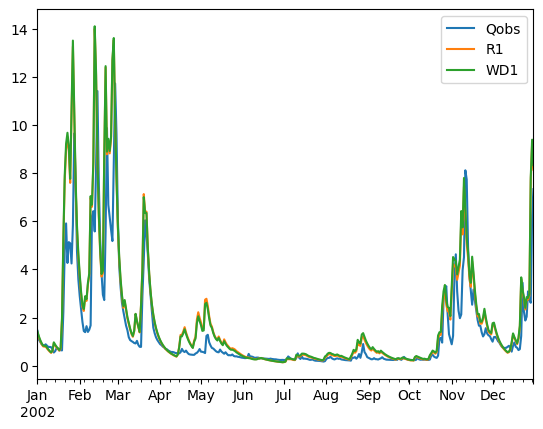

In [210]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-2001','09-30-2015', freq='D'))

gauge_id="DERP2003"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["R1"] = outputr1DERP2003[0]
Qtimeseries["WD1"] = outputDERP2003[0]


1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2002"].plot()

<Axes: >

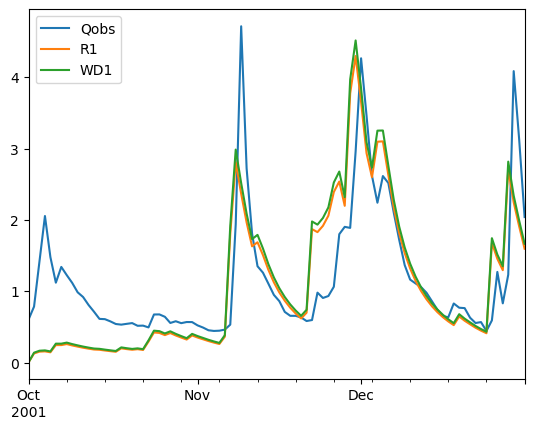

In [149]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-2001','09-30-2015', freq='D'))

gauge_id="DERP2003"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["R1"] = outputr1DERP2003[0]
Qtimeseries["WD1"] = outputDERP2003[0]


1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2001"].plot()

In [140]:
model.get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 3.0773161717474986,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 0.5080092760200876,
 'high_unsaturated_Ce': 1.019118258680726,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 0.7921739483743102,
 'high_unsaturated_bacon': 264.0,
 'high_slowhigh_k': 6.10008776565738e-05,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 3.0773161717474986,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 0.5080092760200876,
 'general_unsaturated_Ce': 1.019118258680726,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 0.7921739483743102,
 'general_unsaturated_bacon': 264.0,
 'general_lowersplitter_splitpar': 0.500035551548686,
 'general_slow_k': 0.08948126331670521,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 2.9751926331408343,
 'general_fast_k': 0.19284203607196362,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 3.0773161717474986,
 'low_snow_m': 2.0,
 'low_unsaturated_Csmax': 0.508009

In [139]:
waterdeficit_mean

{'BEWA0066': 264.0,
 'BEWA0067': 236.4,
 'BEWA0087': 288.7,
 'BEWA0106': 316.7,
 'BEWA0107': 252.0,
 'BEWA0119': 269.3,
 'DEBU1956': 348.8,
 'DEBU1957': 354.5,
 'DEBU1958': 336.2,
 'DEBU1959': 329.2,
 'DERP2003': 320.7,
 'DERP2004': 288.7,
 'DERP2005': 315.3,
 'DERP2006': 257.9,
 'DERP2007': 306.4,
 'DERP2008': 311.9,
 'DERP2010': 301.1,
 'DERP2011': 314.9,
 'DERP2013': 357.5,
 'DERP2014': 346.4,
 'DERP2015': 350.9,
 'DERP2016': 351.6,
 'DERP2017': 283.5,
 'DERP2018': 286.6,
 'DERP2021': 258.0,
 'DERP2022': 273.9,
 'DERP2023': 281.9,
 'DERP2024': 295.9,
 'DERP2027': 290.3,
 'DERP2028': 299.3,
 'DERP2029': 306.6,
 'DERP2030': 289.9,
 'DERP2031': 274.5,
 'DERP2033': 300.1,
 'DERP2036': 308.1,
 'FR000124': 175.3,
 'FR000125': 182.3,
 'FR000126': 180.4,
 'FR000127': 180.5,
 'FR000128': 192.5,
 'FR000132': 191.7,
 'FR000133': 204.7,
 'FR000134': 215.5,
 'FR000135': 226.7,
 'FR000136': 319.8,
 'FR000137': 315.9,
 'FR000138': 323.0,
 'FR000139': 323.0,
 'FR000140': 263.1,
 'FR000142': 199.6,


In [144]:
264.0*0.5*0.1

13.200000000000001

In [135]:
model.get_states()

{'BEWA0066_high_snow_S0': 0.0,
 'BEWA0066_high_unsaturated_S0': 38.53878705330178,
 'BEWA0066_high_slowhigh_S0': 115.65324702329255,
 'BEWA0066_general_snow_S0': 0.0,
 'BEWA0066_general_unsaturated_S0': 38.53878705330178,
 'BEWA0066_general_slow_S0': 6.1725916542894605,
 'BEWA0066_general_lag-fun_lag': [array([0., 0., 0.])],
 'BEWA0066_general_fast_S0': 0.8579370617333913,
 'BEWA0066_low_snow_S0': 0.0,
 'BEWA0066_low_unsaturated_S0': 38.53878705330178,
 'BEWA0066_low_fast_S0': 14.087894566510917,
 'BEWA0067_high_snow_S0': 0.0,
 'BEWA0067_high_unsaturated_S0': 11.82,
 'BEWA0067_high_slowhigh_S0': 0.0,
 'BEWA0067_general_snow_S0': 0.0,
 'BEWA0067_general_unsaturated_S0': 11.82,
 'BEWA0067_general_slow_S0': 0.0,
 'BEWA0067_general_lag-fun_lag': None,
 'BEWA0067_general_fast_S0': 0.0,
 'BEWA0067_low_snow_S0': 0.0,
 'BEWA0067_low_unsaturated_S0': 11.82,
 'BEWA0067_low_fast_S0': 0.0,
 'BEWA0087_high_snow_S0': 0.0,
 'BEWA0087_high_unsaturated_S0': 14.435,
 'BEWA0087_high_slowhigh_S0': 0.0,
 '

In [150]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

def calculate_hydro_year(date, first_month=10):
    """
    This function calculates the hydrological year from a date. The
    hydrological year starts on the month defined by the parameter first_month.

    Parameters
    ----------
    date : pandas.core.indexes.datetimes.DatetimeIndex
        Date series
    first_month : int
        Number of the first month of the hydrological year

    Returns
    -------
    numpy.ndarray
        Hydrological year time series
    """

    hydrological_year = date.year.values.copy()
    hydrological_year[date.month >= first_month] += 1

    return hydrological_year

def run_model_superflexpy_wd_rd(catchments_ids, best_params_dict_model, perm_areas_model, waterdeficit_mean_model):
    
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']
    

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes

    for cat_id in catchments_ids:


        unsaturated = CustomUnsaturatedReservoir(
            parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': waterdeficit_mean_model[cat_id].round(1)},
            states={'S0': 10.0},
            approximation=num_app,
            id='unsaturated')


        general = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [lower_splitter],
                [slow, lag_fun],
                [lower_transparent, fast],
                [lower_junction],
            ],
            id='general'
        )

        low = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [fast],
            ],
            id='low'
        )

        high = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [slowhigh],
            ],
            id='high'
        )

        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        
        node.set_input(inputs[cat_id])  # Correct way to set inputs
        
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        #globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )


    model.reset_states()

    model.set_timestep(1.0)

    # Apply shared parameters to the whole network (this is due to the way we set Csumax)
    for key in model._content_pointer.keys():
        i = model._content_pointer[key] 
        model._content[i].set_parameters(best_params_dict_model)

    #model.set_parameters(best_params_dict_model)

    #hyd_mod.reset_states()
    output = model.get_output()

    return output


def run_model_superflexpy_wd(catchments_ids, best_params_dict_model, perm_areas_model, waterdeficit_mean_model):
    
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']
    

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes

    for cat_id in catchments_ids:


        unsaturated = CustomUnsaturatedReservoir(
            parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': waterdeficit_mean_model[cat_id].round(1)},
            states={'S0': 10.0},
            approximation=num_app,
            id='unsaturated')


        general = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [lower_splitter],
                [slow, lag_fun],
                [lower_transparent, fast],
                [lower_junction],
            ],
            id='general'
        )

        low = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [fast],
            ],
            id='low'
        )

        high = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [slowhigh],
            ],
            id='high'
        )

        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        
        node.set_input(inputs[cat_id])  # Correct way to set inputs
        
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        #globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )


    model.reset_states()

    model.set_timestep(1.0)

    # Apply shared parameters to the whole network (this is due to the way we set Csumax)
    for key in model._content_pointer.keys():
        i = model._content_pointer[key] 
        model._content[i].set_parameters(best_params_dict_model)

    #model.set_parameters(best_params_dict_model)

    #hyd_mod.reset_states()
    output = model.get_output()

    return output

def run_model_superflexpy(catchments_ids, best_params_dict_model, perm_areas_model):
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    
    unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
    )
    
    general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general')

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low')

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high')

    for cat_id in catchments_ids:
        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs

    model.set_timestep(1.0)
    model.set_parameters(best_params_dict_model)

    output = model.get_output()

    return output



def generate_nse_results(catchments_ids, daterange, output, observations, quality_masks):


    # Create an empty list to store results
    nse_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        hydro_year = calculate_hydro_year(date=Qtimeseries.index, first_month=10)

        nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values, 
                                    expo=0.5)
                
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        qmean_obs = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])
        qmean_sim = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])
        
        try:
            slope_obs = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])["Sawicz"]
            slope_sim = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])["Sawicz"]
        except:
            slope_obs = np.nan
            slope_sim = np.nan

        try:
            hfd_obs = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]
            hfd_sim = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]
        except:
            hfd_obs = np.nan
            hfd_sim = np.nan


        try:
            bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
            
            nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    expo=0.5)
        except:
            nse_value_bfi = np.nan


        nse_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "nse": nse_value,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "nse_value_bfi": nse_value_bfi,
            "qmean_obs": qmean_obs,
            "qmean_sim": qmean_sim,
            "slope_obs": slope_obs,
            "slope_sim": slope_sim,
            "hfd_obs": hfd_obs,
            "hfd_sim": hfd_sim
            })

    # Convert results to DataFrame
    nse_results_df = pd.DataFrame(nse_results_cal)

    return nse_results_df

In [ ]:
    path_inputs = '../data/models/input/subset_2001_2015'

    inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
    observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
    areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
    perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
    perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
    perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
    quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
    rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
    waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

    perm_areas_model = perm_areas
    best_params_dict_model = best_params_dict_model_r_WD_1
    waterdeficit_mean_model = waterdeficit_mean

    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']
    

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes

    for cat_id in catchments_ids:


        unsaturated = CustomUnsaturatedReservoir(
            parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': waterdeficit_mean_model[cat_id].round(1)},
            states={'S0': 10.0},
            approximation=num_app,
            id='unsaturated')


        general = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [lower_splitter],
                [slow, lag_fun],
                [lower_transparent, fast],
                [lower_junction],
            ],
            id='general'
        )

        low = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [fast],
            ],
            id='low'
        )

        high = Unit(
            layers=[
                [upper_splitter],
                [snow, upper_transparent],
                [upper_junction],
                [unsaturated],
                [slowhigh],
            ],
            id='high'
        )

        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        
        node.set_input(inputs[cat_id])  # Correct way to set inputs
        
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        #globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    model.set_timestep(1.0)

    # Apply shared parameters to the whole network (this is due to the way we set Csumax)
    for key in model._content_pointer.keys():
        i = model._content_pointer[key] 
        model._content[i].set_parameters(best_params_dict_model)

    #model.set_parameters(best_params_dict_model)

    #hyd_mod.reset_states()
    output_regional_wd2 = model.get_output()

In [224]:
model.get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 3.0773161717474986,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 0.5080092760200876,
 'high_unsaturated_Ce': 1.019118258680726,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 0.7921739483743102,
 'high_unsaturated_bacon': 264.0,
 'high_slowhigh_k': 6.10008776565738e-05,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 3.0773161717474986,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 0.5080092760200876,
 'general_unsaturated_Ce': 1.019118258680726,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 0.7921739483743102,
 'general_unsaturated_bacon': 264.0,
 'general_lowersplitter_splitpar': 0.500035551548686,
 'general_slow_k': 0.08948126331670521,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 2.9751926331408343,
 'general_fast_k': 0.19284203607196362,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 3.0773161717474986,
 'low_snow_m': 2.0,
 'low_unsaturated_Csmax': 0.508009

In [225]:
output_regional

{'BEWA0067': [array([0.00327747, 0.14805634, 0.16562337, ..., 1.14637729, 1.00566585,
         0.88921781])],
 'BEWA0087': [array([0.01350661, 0.19437833, 0.28947993, ..., 1.27500395, 1.10940869,
         0.97357459])],
 'BEWA0106': [array([0.00142083, 0.07806733, 0.09371349, ..., 0.84973286, 0.75696647,
         0.67838496])],
 'BEWA0107': [array([0.00571998, 0.08508815, 0.11828536, ..., 1.07496664, 0.9436281 ,
         0.83661617])],
 'DERP2005': [array([0.00396613, 0.0939737 , 0.12819024, ..., 0.83770997, 0.74429176,
         0.66602505])],
 'DERP2006': [array([0.00597043, 0.14896213, 0.1923987 , ..., 1.03188052, 0.9094234 ,
         0.80860738])],
 'DERP2008': [array([0.00340232, 0.12211076, 0.15515729, ..., 0.89855744, 0.79916788,
         0.71555979])],
 'DERP2010': [array([0.01793785, 0.15088783, 0.27466796, ..., 0.78769873, 0.71118869,
         0.64944568])],
 'DERP2013': [array([0.00254741, 0.00278251, 0.01022101, ..., 0.32239688, 0.315145  ,
         0.30897328])],
 'DERP2015

In [23]:
def generate_kge_results(catchments_ids, daterange, output):

    # Create an empty list to store results
    kge_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        kge_value = 1 - obj_fun_kge(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values)
        
        mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
        mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        try:
            bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
            
            kge_value_bfi = 1 - obj_fun_kge(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    )
        except:
            kge_value_bfi = np.nan


        kge_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "kge": kge_value,
            "q_mean_obs": mean_q_obs,
            "q_mean_calc": mean_q_calc,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "kge_value_bfi": kge_value_bfi
            })

    # Convert results to DataFrame
    kge_results_cal_c_1_100 = pd.DataFrame(kge_results_cal)

    return kge_results_cal_c_1_100

In [241]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_wd2 = run_model_superflexpy_wd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_WD_2, perm_areas_model= perm_areas, waterdeficit_mean_model = waterdeficit_mean)
output_regional_rd2 = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_RD_2, perm_areas_model = perm_areas, waterdeficit_mean_model = rootdepth_mean)
output_regional2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)

nse_results_cal_r_2_100_wd = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional_wd2, observations, quality_masks)
nse_results_cal_r_2_100_rd = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional_rd2, observations, quality_masks)
nse_results_cal_r_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional2, observations, quality_masks)

In [242]:
nse_results_cal_r_2_100_wd.iloc[0:10]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.824927,0.514795,0.583671,0.827926,1.238351,1.115025,3.347668,2.391585,125.769231,136.230769
1,Schoenberg,BEWA0067,0.771400,0.448057,0.564805,0.760002,1.412586,1.234102,3.448610,2.480955,122.307692,136.461538
2,Martelange,BEWA0087,-17.138199,0.715474,0.557093,NaN,0.196649,1.143702,1.740044,2.413457,149.666667,130.166667
3,Reuland,BEWA0106,0.723384,0.481832,0.595993,NaN,1.011804,0.827004,4.246454,2.273523,126.153846,139.615385
4,Lommersweiler,BEWA0107,0.739875,0.569622,0.575472,NaN,1.142034,1.204714,3.281075,2.435425,131.250000,138.666667
5,Ouren,BEWA0119,0.810758,0.505083,0.581599,NaN,1.195583,1.101824,3.519631,2.380066,121.100000,133.400000
6,BundespegelPerl,DEBU1956,0.862835,0.614257,0.634671,0.892614,0.966259,0.927918,2.414206,2.359645,131.000000,135.461538
7,BundespegelFremersdorf,DEBU1957,0.844550,0.609906,0.649609,0.861145,0.782447,0.689833,2.116811,2.243677,132.923077,140.000000
8,BundespegelTrierUp,DEBU1958,0.883094,0.626954,0.641183,0.897836,0.938375,0.842378,2.401219,2.263417,131.230769,136.538462
9,BundespegelCochem,DEBU1959,0.868950,0.615673,0.642227,0.908678,0.897177,0.821772,2.589688,2.259893,131.461538,136.538462


In [243]:
nse_results_cal_r_2_100_rd.iloc[0:10]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.824417,0.514795,0.582059,0.817319,1.238351,1.138619,3.347668,2.384945,125.769231,135.692308
1,Schoenberg,BEWA0067,0.762239,0.448057,0.567632,0.749946,1.412586,1.214176,3.448610,2.447094,122.307692,137.461538
2,Martelange,BEWA0087,-19.274358,0.715474,0.548980,NaN,0.196649,1.222349,1.740044,2.401975,149.666667,127.583333
3,Reuland,BEWA0106,0.734793,0.481832,0.584689,NaN,1.011804,0.916983,4.246454,2.271831,126.153846,135.769231
4,Lommersweiler,BEWA0107,0.723308,0.569622,0.572566,NaN,1.142034,1.245221,3.281075,2.441579,131.250000,137.000000
5,Ouren,BEWA0119,0.811774,0.505083,0.579563,NaN,1.195583,1.126860,3.519631,2.350918,121.100000,132.800000
6,BundespegelPerl,DEBU1956,0.857135,0.614257,0.634199,0.883471,0.966259,0.899434,2.414206,2.312415,131.000000,136.461538
7,BundespegelFremersdorf,DEBU1957,0.840017,0.609906,0.645288,0.845547,0.782447,0.690290,2.116811,2.262718,132.923077,139.153846
8,BundespegelTrierUp,DEBU1958,0.877350,0.626954,0.639738,0.885865,0.938375,0.832440,2.401219,2.257179,131.230769,136.538462
9,BundespegelCochem,DEBU1959,0.864245,0.615673,0.640770,0.899691,0.897177,0.812777,2.589688,2.252726,131.461538,136.538462


In [244]:
nse_results_cal_r_2_100.iloc[0:10]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.822319,0.514795,0.576639,0.839581,1.238351,1.079690,3.347668,2.485811,125.769231,136.846154
1,Schoenberg,BEWA0067,0.758392,0.448057,0.560471,0.766727,1.412586,1.176877,3.448610,2.512373,122.307692,138.076923
2,Martelange,BEWA0087,-16.949454,0.715474,0.545566,NaN,0.196649,1.132260,1.740044,2.592648,149.666667,130.166667
3,Reuland,BEWA0106,0.741365,0.481832,0.581194,NaN,1.011804,0.828265,4.246454,2.434052,126.153846,137.615385
4,Lommersweiler,BEWA0107,0.751160,0.569622,0.570166,NaN,1.142034,1.161058,3.281075,2.491453,131.250000,139.500000
5,Ouren,BEWA0119,0.807375,0.505083,0.574185,NaN,1.195583,1.069741,3.519631,2.480290,121.100000,133.900000
6,BundespegelPerl,DEBU1956,0.871100,0.614257,0.636117,0.902149,0.966259,0.927219,2.414206,2.356581,131.000000,136.153846
7,BundespegelFremersdorf,DEBU1957,0.857695,0.609906,0.649795,0.873731,0.782447,0.708218,2.116811,2.300685,132.923077,139.461538
8,BundespegelTrierUp,DEBU1958,0.891615,0.626954,0.640565,0.906969,0.938375,0.846865,2.401219,2.290035,131.230769,136.538462
9,BundespegelCochem,DEBU1959,0.878347,0.615673,0.641275,0.918996,0.897177,0.826183,2.589688,2.288962,131.461538,136.692308


In [245]:
# Assuming these are pandas Series or DataFrames with the same index
diff = nse_results_cal_r_2_100.nse - nse_results_cal_r_2_100_wd.nse

# Count how many are < 0
count_below_zero = (diff < 0).sum()

print("Number of values below 0:", count_below_zero)

Number of values below 0: 49


In [246]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_wd_88012 = run_model_superflexpy_wd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_WD_2_8801, perm_areas_model= perm_areas, waterdeficit_mean_model= waterdeficit_mean)
output_regional_rd_88012 = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_RD_2_8801, perm_areas_model = perm_areas, waterdeficit_mean_model = rootdepth_mean)
output_regional_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)

In [247]:
nse_results_cal_r_2_100_wd_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_wd_88012, observations, quality_masks)
nse_results_cal_r_2_100_rd_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_rd_88012, observations, quality_masks)
nse_results_cal_r_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_88012, observations, quality_masks)

In [251]:
nse_results_cal_r_2_100_wd_8801.iloc[0:10]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.871826,0.530439,0.575517,NaN,1.673626,1.811629,3.347045,3.494684,126.666667,128.666667
1,Schoenberg,BEWA0067,0.834580,0.469761,0.574654,NaN,1.856752,1.901240,3.923949,3.336630,128.000000,133.500000
2,Martelange,BEWA0087,-26.263747,0.743091,0.526094,NaN,0.198900,1.395833,1.878544,3.559560,164.500000,124.625000
3,Reuland,BEWA0106,0.802778,0.510228,0.561868,NaN,1.269762,1.265603,4.122925,3.520321,127.222222,129.666667
4,Lommersweiler,BEWA0107,0.757789,0.567507,0.540967,NaN,1.473218,1.755506,3.395738,3.405896,140.000000,139.000000
5,Ouren,BEWA0119,0.845992,0.517122,0.558442,NaN,1.431923,1.620123,3.211269,3.292889,127.750000,133.750000
6,BundespegelPerl,DEBU1956,0.912159,0.590739,0.623177,0.935270,1.125983,1.162981,2.635162,2.644161,132.583333,132.833333
7,BundespegelFremersdorf,DEBU1957,0.888847,0.606890,0.649384,0.889774,0.910863,0.879543,2.008244,2.356416,134.750000,136.416667
8,BundespegelTrierUp,DEBU1958,0.919287,0.595567,0.626514,0.924050,1.019842,1.075673,2.305969,2.634271,131.333333,132.750000
9,BundespegelCochem,DEBU1959,0.913383,0.606366,0.627290,0.942765,1.080499,1.054714,2.512145,2.626473,132.416667,132.916667


In [252]:
nse_results_cal_r_2_100_rd_8801.iloc[0:10]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.854640,0.530439,0.583005,NaN,1.673626,1.755680,3.347045,2.877752,126.666667,139.000000
1,Schoenberg,BEWA0067,0.808038,0.469761,0.584477,NaN,1.856752,1.840157,3.923949,2.715628,128.000000,147.000000
2,Martelange,BEWA0087,-26.557948,0.743091,0.531523,NaN,0.198900,1.425046,1.878544,3.135804,164.500000,128.250000
3,Reuland,BEWA0106,0.753210,0.510228,0.567318,NaN,1.269762,1.284795,4.122925,2.962243,127.222222,134.444444
4,Lommersweiler,BEWA0107,0.750650,0.567507,0.545578,NaN,1.473218,1.712067,3.395738,3.069807,140.000000,146.500000
5,Ouren,BEWA0119,0.831700,0.517122,0.566657,NaN,1.431923,1.572212,3.211269,2.881008,127.750000,142.750000
6,BundespegelPerl,DEBU1956,0.901442,0.590739,0.622140,0.934778,1.125983,1.115309,2.635162,2.716431,132.583333,136.333333
7,BundespegelFremersdorf,DEBU1957,0.867564,0.606890,0.643125,0.860587,0.910863,0.875980,2.008244,2.492230,134.750000,138.416667
8,BundespegelTrierUp,DEBU1958,0.905231,0.595567,0.625760,0.917987,1.019842,1.049429,2.305969,2.641897,131.333333,136.000000
9,BundespegelCochem,DEBU1959,0.899594,0.606366,0.626656,0.931719,1.080499,1.031032,2.512145,2.627919,132.416667,136.250000


In [253]:
nse_results_cal_r_2_100_8801.iloc[0:10]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.873369,0.530439,0.578778,NaN,1.673626,1.699499,3.347045,3.113609,126.666667,137.333333
1,Schoenberg,BEWA0067,0.817458,0.469761,0.578759,NaN,1.856752,1.804551,3.923949,2.762987,128.000000,142.500000
2,Martelange,BEWA0087,-24.083205,0.743091,0.528830,NaN,0.198900,1.331920,1.878544,3.259683,164.500000,128.500000
3,Reuland,BEWA0106,0.789513,0.510228,0.564155,NaN,1.269762,1.197428,4.122925,3.237505,127.222222,134.111111
4,Lommersweiler,BEWA0107,0.790923,0.567507,0.544528,NaN,1.473218,1.624872,3.395738,3.186489,140.000000,146.500000
5,Ouren,BEWA0119,0.844908,0.517122,0.563309,NaN,1.431923,1.522472,3.211269,2.988209,127.750000,141.000000
6,BundespegelPerl,DEBU1956,0.910530,0.590739,0.623062,0.939501,1.125983,1.141329,2.635162,2.756213,132.583333,134.333333
7,BundespegelFremersdorf,DEBU1957,0.878280,0.606890,0.647631,0.865497,0.910863,0.896190,2.008244,2.420000,134.750000,136.750000
8,BundespegelTrierUp,DEBU1958,0.914120,0.595567,0.626611,0.920058,1.019842,1.064201,2.305969,2.690562,131.333333,134.416667
9,BundespegelCochem,DEBU1959,0.908163,0.606366,0.627301,0.937192,1.080499,1.045337,2.512145,2.684609,132.416667,134.416667


In [254]:
# Assuming these are pandas Series or DataFrames with the same index
diff = nse_results_cal_r_2_100_8801.nse - nse_results_cal_r_2_100_wd_8801.nse

# Count how many are < 0
count_below_zero = (diff < 0).sum()

print("Number of values below 0:", count_below_zero)

Number of values below 0: 62


In [255]:
# Assuming these are pandas Series or DataFrames with the same index
diff = nse_results_cal_r_2_100_8801.nse - nse_results_cal_r_2_100_rd_8801.nse

# Count how many are < 0
count_below_zero = (diff < 0).sum()

print("Number of values below 0:", count_below_zero)

Number of values below 0: 33


In [256]:
path_inputs = '../data/models/input/subset_1988_2001'

observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'

observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

output_regional_cal2 = {
    key: [np.concatenate([output_regional_88012[key][0], output_regional2[key][0]])]
    for key in output_regional_88012
    if key in output_regional2  # ensures keys match
}

output_regional_rd_cal2 = {
    key: [np.concatenate([output_regional_rd_88012[key][0], output_regional_rd2[key][0]])]
    for key in output_regional_rd_88012
    if key in output_regional_rd2  # ensures keys match
}

output_regional_wd_cal2 = {
    key: [np.concatenate([output_regional_wd_88012[key][0], output_regional_wd2[key][0]])]
    for key in output_regional_wd_88012
    if key in output_regional_wd2  # ensures keys match
}

In [257]:
nse_results_cal_r_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_cal2, observations_cal, quality_masks_cal)
nse_results_cal_r_2_rd_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_rd_cal2, observations_cal, quality_masks_cal)
nse_results_cal_r_2_wd_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_wd_cal2, observations_cal, quality_masks_cal)

In [258]:
# Assuming these are pandas Series or DataFrames with the same index
diff = nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_r_2_wd_100_complete_cal.nse

# Count how many are < 0
count_below_zero = (diff < 0).sum()

print("Number of values below 0:", count_below_zero)

Number of values below 0: 51


In [259]:
# First half
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


# Second half
list_cal = ['FR003303',
 'FR000144',
 'DERP2033',
 'FR003275',
 'DERP2004',
 'FR003271',
 #'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']



In [260]:
data_diff_cal_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_r_2_rd_100_complete_cal.nse)
data_diff_cal_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_r_2_wd_100_complete_cal.nse

data_diff_cal_complete2.index = nse_results_cal_r_2_rd_100_complete_cal.basin

data_diff_cal_complete2 = data_diff_cal_complete2.loc[~data_diff_cal_complete2.index.isin(list_cal)]

data_diff_cal_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_rd1"] = nse_results_cal_r_2_rd_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_wd1"] = nse_results_cal_r_2_wd_100_complete_cal.set_index("basin", inplace = False).nse

data_diff_cal_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_rd1"] = nse_results_cal_r_2_rd_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_wd1"] = nse_results_cal_r_2_wd_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_obs
data_diff_cal_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_rd1"] = nse_results_cal_r_2_rd_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_wd1"] = nse_results_cal_r_2_wd_100_complete_cal.set_index("basin", inplace = False).bfi_sim

data_diff_cal_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_obs
data_diff_cal_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_rd1"] = nse_results_cal_r_2_rd_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_wd1"] = nse_results_cal_r_2_wd_100_complete_cal.set_index("basin", inplace = False).qmean_sim

data_diff_cal_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_obs
data_diff_cal_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_rd1"] = nse_results_cal_r_2_rd_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_wd1"] = nse_results_cal_r_2_wd_100_complete_cal.set_index("basin", inplace = False).slope_sim

data_diff_cal_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_obs
data_diff_cal_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_rd1"] = nse_results_cal_r_2_rd_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_wd1"] = nse_results_cal_r_2_wd_100_complete_cal.set_index("basin", inplace = False).hfd_sim


data_diff_cal_complete2 = data_diff_cal_complete2[data_diff_cal_complete2.nse_r1 > -10.0]
data_diff_cal_complete2

,nse,nse_rg,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,...,qmean_rd1,qmean_wd1,slope_obs,slope_r1,slope_rd1,slope_wd1,hfd_obs,hfd_r1,hfd_rd1,hfd_wd1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.000580,-0.003024,0.829036,0.828456,0.832060,NaN,NaN,NaN,0.515742,0.573456,...,1.297658,1.290774,3.400558,2.743290,2.591278,2.713422,126.294118,137.294118,136.705882,135.294118
BEWA0067,-0.001979,-0.014028,0.768075,0.770053,0.782103,NaN,NaN,NaN,0.446878,0.560397,...,1.351097,1.378269,3.527884,2.698627,2.588746,2.712549,123.437500,138.937500,138.937500,136.437500
BEWA0106,0.015866,0.003133,0.763070,0.747204,0.759937,NaN,NaN,NaN,0.496805,0.572535,...,1.085290,1.024455,4.063631,2.783658,2.594139,2.776009,127.000000,136.521739,135.565217,135.956522
BEWA0107,0.032390,0.020269,0.759315,0.726925,0.739046,NaN,NaN,NaN,0.565063,0.557326,...,1.451077,1.442967,3.418299,2.795479,2.697096,2.826382,133.588235,141.411765,139.588235,139.000000
BEWA0119,0.001862,-0.003070,0.816860,0.814997,0.819929,NaN,NaN,NaN,0.508101,0.567503,...,1.323433,1.326873,3.336434,2.753243,2.630035,2.781035,123.266667,136.400000,136.133333,134.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.016502,0.009709,0.784399,0.767897,0.774690,NaN,NaN,NaN,0.516853,0.570479,...,1.051614,0.966914,4.331634,2.573227,2.394486,2.414939,121.769231,135.076923,131.000000,135.769231
LU000016,-0.012268,-0.000012,0.657855,0.670124,0.657867,NaN,NaN,NaN,0.564940,0.555673,...,0.693974,0.668173,2.005883,2.774134,2.545615,2.606058,133.615385,134.384615,135.769231,136.538462
LU000017,-0.005300,0.004412,0.844705,0.850004,0.840292,NaN,NaN,NaN,0.572433,0.606628,...,0.877714,0.842817,2.459555,2.377061,2.227885,2.252909,127.307692,137.769231,136.230769,138.384615


In [261]:
data_diff_cal_complete2[data_diff_cal_complete2.nse_rg < 0]

,nse,nse_rg,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,...,qmean_rd1,qmean_wd1,slope_obs,slope_r1,slope_rd1,slope_wd1,hfd_obs,hfd_r1,hfd_rd1,hfd_wd1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.000580,-0.003024,0.829036,0.828456,0.832060,NaN,NaN,NaN,0.515742,0.573456,...,1.297658,1.290774,3.400558,2.743290,2.591278,2.713422,126.294118,137.294118,136.705882,135.294118
BEWA0067,-0.001979,-0.014028,0.768075,0.770053,0.782103,NaN,NaN,NaN,0.446878,0.560397,...,1.351097,1.378269,3.527884,2.698627,2.588746,2.712549,123.437500,138.937500,138.937500,136.437500
BEWA0119,0.001862,-0.003070,0.816860,0.814997,0.819929,NaN,NaN,NaN,0.508101,0.567503,...,1.323433,1.326873,3.336434,2.753243,2.630035,2.781035,123.266667,136.400000,136.133333,134.133333
DERP2003,0.004263,-0.003374,0.859051,0.854788,0.862425,0.866755,0.874493,0.874101,0.559353,0.595312,...,1.001669,0.976160,2.285585,2.625498,2.499380,2.597532,126.346154,134.923077,134.538462,133.961538
DERP2006,0.008654,-0.011326,0.773461,0.764807,0.784787,0.815339,0.791175,0.819895,0.439622,0.564202,...,1.229458,1.281937,4.017057,2.762081,2.617316,2.800487,122.230769,136.076923,137.192308,133.384615
DERP2007,-0.000643,-0.003449,0.794304,0.794947,0.797753,0.860186,0.861097,0.857116,0.500914,0.603527,...,0.997519,1.003919,2.915571,2.547372,2.427567,2.547352,124.884615,136.769231,137.115385,135.576923
DERP2013,0.069403,-0.057072,0.193999,0.124596,0.251072,-0.388054,-0.551681,-0.239021,0.813898,0.830439,...,0.762347,0.751895,0.958560,1.600822,1.805823,1.462914,161.346154,164.307692,155.807692,166.500000
DERP2017,0.010571,-0.007717,0.837338,0.826768,0.845055,0.832069,0.820318,0.843136,0.604066,0.621417,...,1.070501,1.099667,2.692027,2.462163,2.423030,2.392097,133.500000,137.192308,137.269231,135.576923
DERP2021,-0.008370,-0.015876,0.803578,0.811948,0.819455,0.846225,0.841302,0.856461,0.470385,0.570024,...,1.199571,1.196549,3.337035,2.750560,2.603479,2.775804,124.500000,137.500000,136.923077,134.884615


<Axes: >

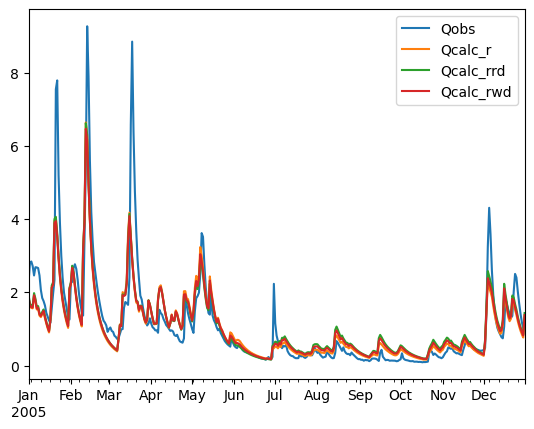

In [262]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000005"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

<Axes: >

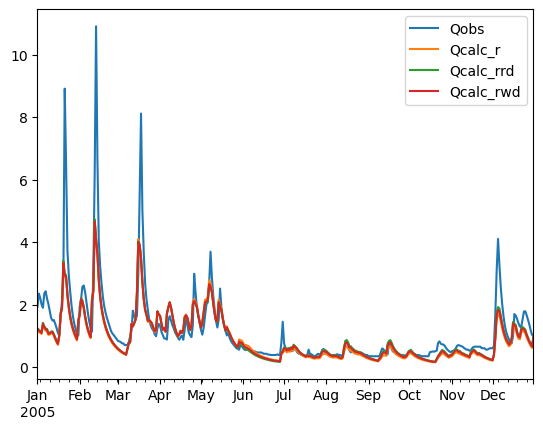

In [263]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2022"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

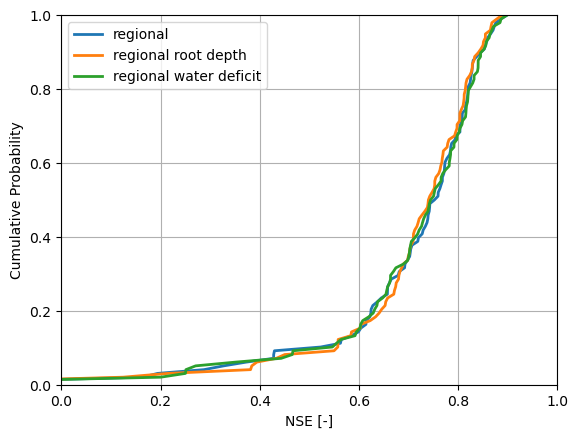

In [264]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_rd1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="regional root depth", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="regional water deficit", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


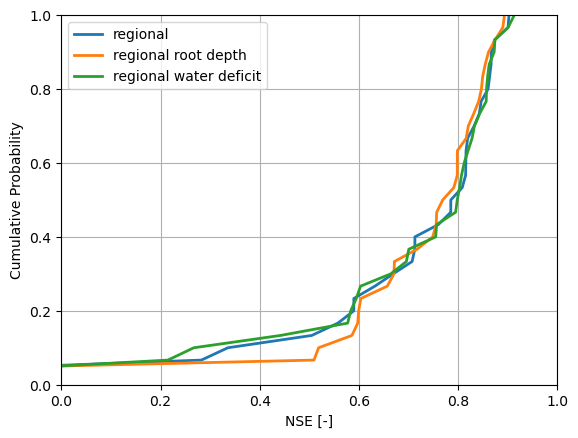

In [265]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_bfi_rd1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_bfi_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="regional root depth", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="regional water deficit", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


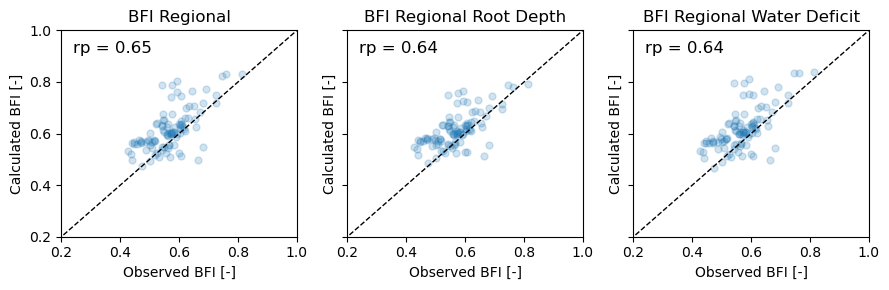

In [266]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_rd1', 'bfi_wd1']
titles = ['BFI Regional', 'BFI Regional Root Depth', 'BFI Regional Water Deficit']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_cal_complete2["bfi_obs"]
    y = data_diff_cal_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_cal_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

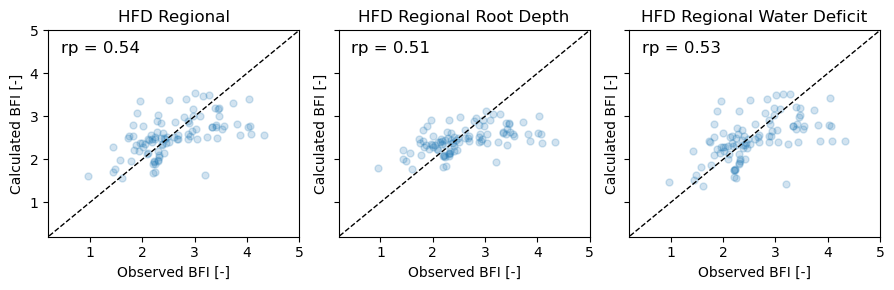

In [267]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['slope_r1', 'slope_rd1', 'slope_wd1']
titles = ['HFD Regional', 'HFD Regional Root Depth', 'HFD Regional Water Deficit']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_cal_complete2["slope_obs"]
    y = data_diff_cal_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 5], [0, 5], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 5.0)
    ax.set_ylim(0.2, 5.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_cal_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

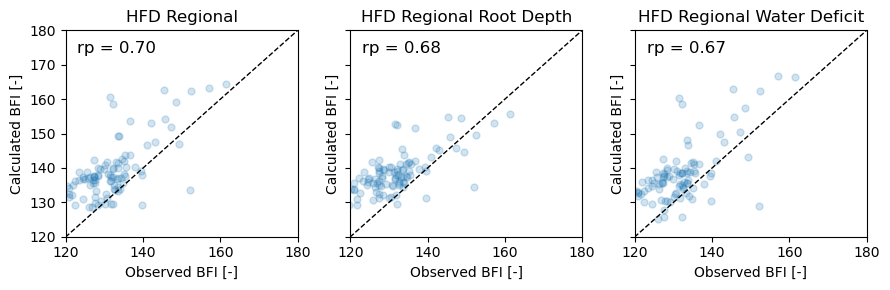

In [268]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['hfd_r1', 'hfd_rd1', 'hfd_wd1']
titles = ['HFD Regional', 'HFD Regional Root Depth', 'HFD Regional Water Deficit']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_cal_complete2["hfd_obs"]
    y = data_diff_cal_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 200], [0, 200], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(120, 180.0)
    ax.set_ylim(120, 180.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_cal_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

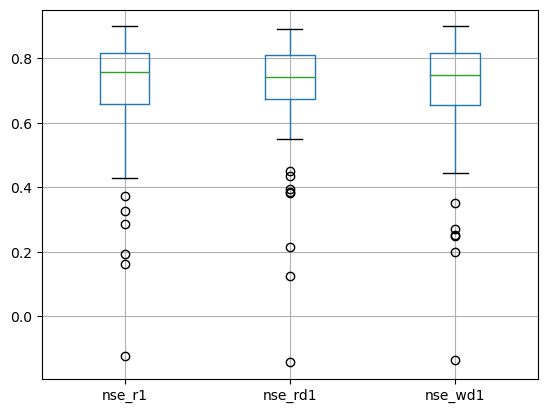

In [269]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal_complete2[data_diff_cal_complete2.nse_wd1 > -6].boxplot(column=["nse_r1","nse_rd1", "nse_wd1"])

# Show the plot
plt.show()


In [270]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()

#Test to check whether is better to keep the same WD as the calibration
path_inputs = '../data/models/input/subset_2001_2015'

waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()


output_regional_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_regional_rd_val2 = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_RD_2, perm_areas_model = perm_areas, waterdeficit_mean_model = rootdepth_mean)
output_regional_wd_val2 = run_model_superflexpy_wd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_WD_2, perm_areas_model = perm_areas, waterdeficit_mean_model = waterdeficit_mean)

In [271]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()

#Test to check whether is better to keep the same WD as the calibration
path_inputs = '../data/models/input/subset_1988_2001'

waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_regional_rd_01152 = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_RD_2_8801, perm_areas_model = perm_areas, waterdeficit_mean_model = rootdepth_mean)
output_regional_wd_01152 = run_model_superflexpy_wd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_WD_2_8801, perm_areas_model = perm_areas, waterdeficit_mean_model = waterdeficit_mean)

In [272]:
output_regional_val_c2 = {
    key: [np.concatenate([output_regional_val2[key][0], output_regional_01152[key][0]])]
    for key in output_regional_01152
    if key in output_regional_val2  # ensures keys match
}

output_regional_rd_val_c2 = {
    key: [np.concatenate([output_regional_rd_val2[key][0], output_regional_rd_01152[key][0]])]
    for key in output_regional_rd_val2
    if key in output_regional_rd_01152  # ensures keys match
}

output_regional_wd_val_c2 = {
    key: [np.concatenate([output_regional_wd_val2[key][0], output_regional_wd_01152[key][0]])]
    for key in output_regional_wd_val2
    if key in output_regional_wd_01152  # ensures keys match
}

In [273]:
nse_results_cal_r_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_val_c2, observations_cal, quality_masks_cal)

In [274]:
nse_results_cal_r_rd_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_rd_val_c2, observations_cal, quality_masks_cal)

In [275]:
nse_results_cal_r_wd_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_wd_val_c2, observations_cal, quality_masks_cal)

In [276]:
data_diff_val_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_r_rd_2_100_complete_val.nse)
data_diff_val_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_r_wd_2_100_complete_val.nse

data_diff_val_complete2.index = nse_results_cal_r_rd_2_100_complete_val.basin

data_diff_val_complete2 = data_diff_val_complete2.loc[~data_diff_val_complete2.index.isin(list_cal)]

data_diff_val_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_rd1"] = nse_results_cal_r_rd_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_wd1"] = nse_results_cal_r_wd_2_100_complete_val.set_index("basin", inplace = False).nse

data_diff_val_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_rd1"] = nse_results_cal_r_rd_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_wd1"] = nse_results_cal_r_wd_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_obs
data_diff_val_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_rd1"] = nse_results_cal_r_rd_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_wd1"] = nse_results_cal_r_wd_2_100_complete_val.set_index("basin", inplace = False).bfi_sim

data_diff_val_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_obs
data_diff_val_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_rd1"] = nse_results_cal_r_rd_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_wd1"] = nse_results_cal_r_wd_2_100_complete_val.set_index("basin", inplace = False).qmean_sim

data_diff_val_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_obs
data_diff_val_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_rd1"] = nse_results_cal_r_rd_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_wd1"] = nse_results_cal_r_wd_2_100_complete_val.set_index("basin", inplace = False).slope_sim

data_diff_val_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_obs
data_diff_val_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_rd1"] = nse_results_cal_r_rd_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_wd1"] = nse_results_cal_r_wd_2_100_complete_val.set_index("basin", inplace = False).hfd_sim


data_diff_val_complete2 = data_diff_val_complete2[data_diff_val_complete2.nse_r1 > -10.0]
data_diff_val_complete2

,nse,nse_rg,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,...,qmean_rd1,qmean_wd1,slope_obs,slope_r1,slope_rd1,slope_wd1,hfd_obs,hfd_r1,hfd_rd1,hfd_wd1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.001266,-0.019899,0.821671,0.822937,0.841570,NaN,NaN,NaN,0.515742,0.571076,...,1.272299,1.281053,3.400558,2.868569,2.662395,3.052897,126.294118,135.352941,135.470588,130.941176
BEWA0067,-0.003556,-0.029720,0.755194,0.758750,0.784914,NaN,NaN,NaN,0.446878,0.555953,...,1.320746,1.370053,3.527884,2.914973,2.632372,3.070598,123.437500,136.937500,138.187500,130.312500
BEWA0106,0.010572,-0.010194,0.750625,0.740053,0.760819,NaN,NaN,NaN,0.496805,0.571488,...,1.084351,1.015576,4.063631,2.857153,2.612676,2.944734,127.000000,136.086957,135.304348,134.434783
BEWA0107,0.032495,0.008876,0.761236,0.728741,0.752360,NaN,NaN,NaN,0.565063,0.555682,...,1.442393,1.429387,3.418299,2.874452,2.734581,2.983352,133.588235,139.411765,138.647059,134.941176
BEWA0119,-0.001852,-0.014912,0.804388,0.806240,0.819300,NaN,NaN,NaN,0.508101,0.565601,...,1.318390,1.321222,3.336434,2.884838,2.678664,2.973937,123.266667,134.800000,134.866667,131.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.026638,-0.025157,0.808341,0.781703,0.833498,NaN,NaN,NaN,0.516853,0.571037,...,1.011208,0.948991,4.331634,2.747176,2.454132,3.074395,121.769231,129.923077,129.307692,126.923077
LU000016,-0.029594,0.054787,0.612132,0.641726,0.557345,NaN,NaN,NaN,0.564940,0.555008,...,0.662389,0.600163,2.005883,2.862135,2.550712,3.138114,133.615385,130.461538,133.076923,130.153846
LU000017,-0.007852,-0.007489,0.834798,0.842650,0.842287,NaN,NaN,NaN,0.572433,0.610980,...,0.839255,0.803644,2.459555,2.438855,2.240898,2.601646,127.307692,134.307692,135.076923,132.230769


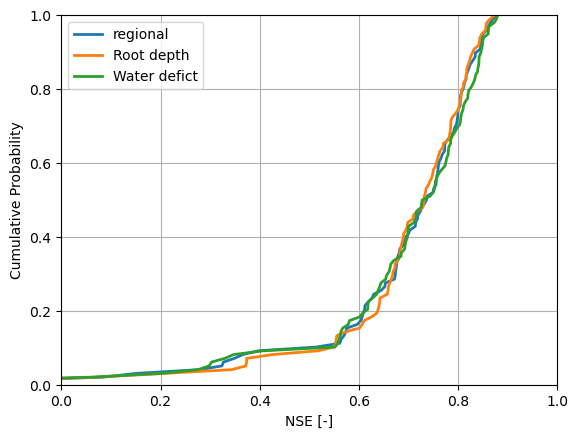

In [278]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_rd1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Root depth", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="Water defict", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [279]:
data_diff_val_complete2[data_diff_val_complete2.nse_wd1>0.82]

,nse,nse_rg,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,...,qmean_rd1,qmean_wd1,slope_obs,slope_r1,slope_rd1,slope_wd1,hfd_obs,hfd_r1,hfd_rd1,hfd_wd1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.001266,-0.019899,0.821671,0.822937,0.841570,NaN,NaN,NaN,0.515742,0.571076,...,1.272299,1.281053,3.400558,2.868569,2.662395,3.052897,126.294118,135.352941,135.470588,130.941176
DEBU1958,0.004390,-0.001741,0.877843,0.873454,0.879584,0.872304,0.875532,0.876965,0.610254,0.631821,...,0.939770,0.946518,2.353118,2.532621,2.430917,2.571098,131.615385,135.923077,136.769231,134.884615
DERP2003,-0.000680,-0.000457,0.846745,0.847425,0.847202,0.848915,0.864516,0.849835,0.559353,0.595020,...,1.001714,0.963697,2.285585,2.671700,2.521659,2.721913,126.346154,134.192308,134.000000,133.230769
DERP2017,0.007323,-0.002196,0.824401,0.817078,0.826597,0.818052,0.808001,0.821898,0.604066,0.619205,...,1.068682,1.085906,2.692027,2.514292,2.446843,2.499518,133.500000,136.615385,137.307692,135.538462
DERP2018,0.008454,0.000539,0.849881,0.841427,0.849343,0.856049,0.843484,0.851914,0.576248,0.599272,...,1.063049,1.070856,2.878603,2.669450,2.555275,2.683135,132.461538,134.846154,135.807692,133.884615
DERP2030,0.014414,0.000893,0.846506,0.832093,0.845613,0.865760,0.841896,0.866368,0.602096,0.601626,...,0.786945,0.784322,2.942743,2.720425,2.484551,2.794109,139.346154,137.807692,139.769231,136.807692
DERP2031,0.005686,-0.000400,0.834316,0.828630,0.834716,0.848611,0.832387,0.849718,0.589492,0.584089,...,1.062220,1.101782,3.030842,2.740422,2.584078,2.783776,133.884615,133.807692,135.461538,132.307692
FR000125,0.006288,-0.018842,0.811675,0.805387,0.830517,NaN,NaN,NaN,0.502305,0.493769,...,2.790244,3.029617,2.796307,2.924991,2.817114,3.074412,125.913043,129.347826,131.347826,125.478261
FR000128,0.005185,-0.023936,0.815908,0.810723,0.839844,NaN,NaN,NaN,0.526235,0.525621,...,2.454361,2.650902,2.878326,2.830932,2.745656,2.961401,127.440000,129.840000,131.400000,125.960000


In [55]:
data_diff_val_complete[data_diff_val_complete.nse_rd1>0.82]

,nse,nse_rg,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,...,qmean_rd1,qmean_wd1,slope_obs,slope_r1,slope_rd1,slope_wd1,hfd_obs,hfd_r1,hfd_rd1,hfd_wd1
basin,,,,,,,,,,,,,,,,,,,,,
DEBU1956,0.010486,0.018465,0.855750,0.845264,0.837285,0.872458,0.863907,0.856067,0.602355,0.616877,...,1.075732,1.094184,2.505087,2.681334,2.478582,2.468217,132.038462,131.615385,134.846154,134.884615
DEBU1957,0.011856,0.015160,0.852117,0.840261,0.836956,0.800945,0.798904,0.799441,0.606413,0.638057,...,0.851092,0.845044,2.049171,2.415749,2.286408,2.276651,134.115385,134.807692,137.576923,138.807692
DEBU1959,0.012778,0.016652,0.861675,0.848897,0.845022,0.889248,0.878465,0.875352,0.609882,0.620274,...,0.990802,0.990788,2.526058,2.592754,2.418850,2.381756,132.230769,131.807692,134.615385,135.423077
DERP2033,0.016028,0.019932,0.838168,0.822141,0.818236,0.845058,0.829972,0.822171,0.513753,0.568890,...,0.817383,0.830057,2.638084,2.924481,2.606793,2.528391,127.961538,131.538462,135.884615,137.076923
FR000140,0.006950,0.020976,0.853276,0.846326,0.832301,NaN,NaN,NaN,0.564786,0.593933,...,1.577325,1.656836,2.688165,2.695714,2.539016,2.537985,127.880000,129.240000,131.960000,130.680000
FR003237,0.003339,0.002988,0.830886,0.827546,0.827898,0.845793,0.830751,0.828611,0.582925,0.573563,...,2.247931,2.367967,2.455219,2.656551,2.538250,2.590849,132.269231,129.038462,131.423077,129.576923
FR003241,0.007487,0.017025,0.837770,0.830282,0.820745,NaN,NaN,NaN,0.572007,0.591357,...,1.894172,2.003109,2.665677,2.601466,2.457600,2.500951,127.500000,127.045455,129.545455,128.045455
FR003249,0.010770,0.015621,0.865700,0.854929,0.850079,NaN,NaN,NaN,0.579674,0.597453,...,1.491301,1.562960,2.729270,2.721966,2.568741,2.553158,128.307692,129.653846,132.653846,131.461538
FR003284,0.011770,0.021396,0.851759,0.839988,0.830362,NaN,NaN,NaN,0.602697,0.621450,...,1.104048,1.127354,2.610227,2.630278,2.458575,2.443857,131.500000,131.961538,134.961538,134.846154


In [56]:
data_diff_val_complete[data_diff_val_complete.nse_r1>0.82]

,nse,nse_rg,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,...,qmean_rd1,qmean_wd1,slope_obs,slope_r1,slope_rd1,slope_wd1,hfd_obs,hfd_r1,hfd_rd1,hfd_wd1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.030656,0.040988,0.838430,0.807774,0.797441,NaN,NaN,NaN,0.515742,0.550943,...,1.319826,1.284266,3.400558,3.121880,2.613868,2.510144,126.294118,129.588235,133.941176,136.647059
DEBU1956,0.010486,0.018465,0.855750,0.845264,0.837285,0.872458,0.863907,0.856067,0.602355,0.616877,...,1.075732,1.094184,2.505087,2.681334,2.478582,2.468217,132.038462,131.615385,134.846154,134.884615
DEBU1957,0.011856,0.015160,0.852117,0.840261,0.836956,0.800945,0.798904,0.799441,0.606413,0.638057,...,0.851092,0.845044,2.049171,2.415749,2.286408,2.276651,134.115385,134.807692,137.576923,138.807692
DEBU1959,0.012778,0.016652,0.861675,0.848897,0.845022,0.889248,0.878465,0.875352,0.609882,0.620274,...,0.990802,0.990788,2.526058,2.592754,2.418850,2.381756,132.230769,131.807692,134.615385,135.423077
DERP2018,0.022595,0.018780,0.826965,0.804369,0.808184,0.831935,0.801531,0.802823,0.576248,0.584843,...,1.141163,1.129996,2.878603,2.740874,2.488639,2.462062,132.461538,130.384615,132.384615,134.230769
DERP2021,0.004844,0.017281,0.823607,0.818763,0.806326,0.855138,0.830631,0.818767,0.470385,0.547328,...,1.269277,1.233486,3.337035,3.064601,2.709418,2.638151,124.500000,131.230769,133.423077,135.923077
DERP2030,0.024040,0.025406,0.831419,0.807379,0.806013,0.851509,0.817945,0.811660,0.602096,0.582102,...,0.853771,0.849459,2.942743,2.801477,2.465517,2.423578,139.346154,132.961538,136.730769,138.576923
DERP2033,0.016028,0.019932,0.838168,0.822141,0.818236,0.845058,0.829972,0.822171,0.513753,0.568890,...,0.817383,0.830057,2.638084,2.924481,2.606793,2.528391,127.961538,131.538462,135.884615,137.076923
FR000140,0.006950,0.020976,0.853276,0.846326,0.832301,NaN,NaN,NaN,0.564786,0.593933,...,1.577325,1.656836,2.688165,2.695714,2.539016,2.537985,127.880000,129.240000,131.960000,130.680000


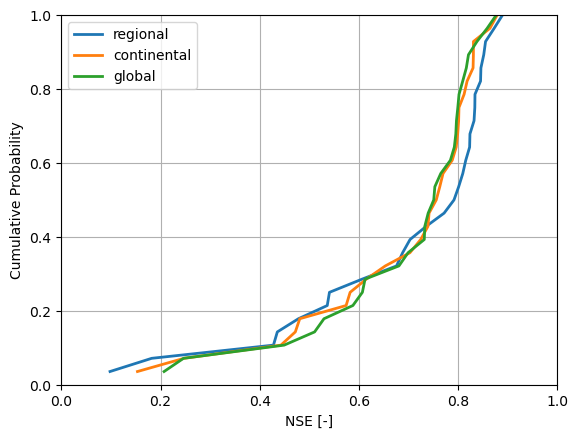

In [239]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete["nse_bfi_rd1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete["nse_bfi_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


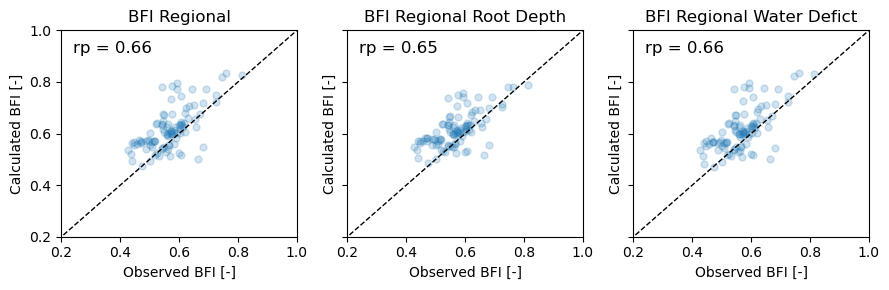

In [280]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_rd1', 'bfi_wd1']
titles = ['BFI Regional', 'BFI Regional Root Depth', 'BFI Regional Water Defict']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["bfi_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

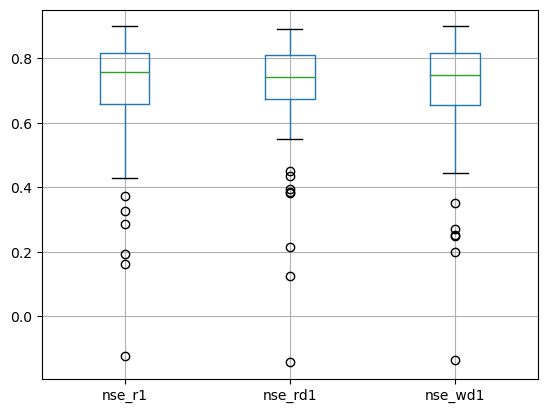

In [281]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal_complete2.boxplot(column=["nse_r1","nse_rd1", "nse_wd1"])

# Show the plot
plt.show()


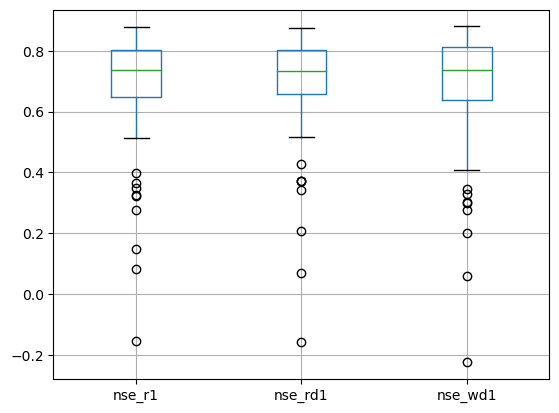

In [282]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_val_complete2.boxplot(column=["nse_r1","nse_rd1", "nse_wd1"])

# Show the plot
plt.show()


<Axes: >

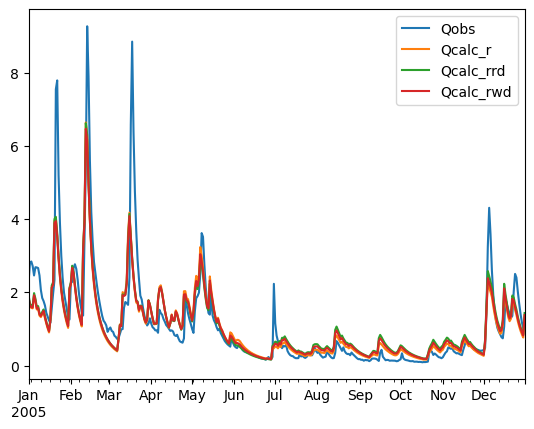

In [283]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000005"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

<Axes: >

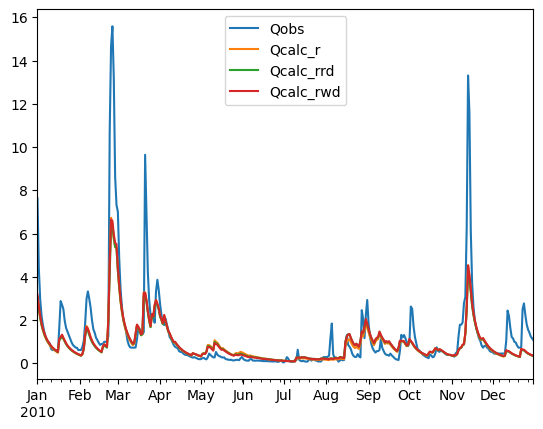

In [284]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-2001','09-30-2015', freq='D'))

gauge_id="DERP2006"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

In [286]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2001', freq='D'))

gauge_id="DERP2006"

Qtimeseries["Qobs"] = observations2[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_88012[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_88012[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_88012[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2000"].plot()

ValueError: Length of values (5113) does not match length of index (4748)

<Axes: >

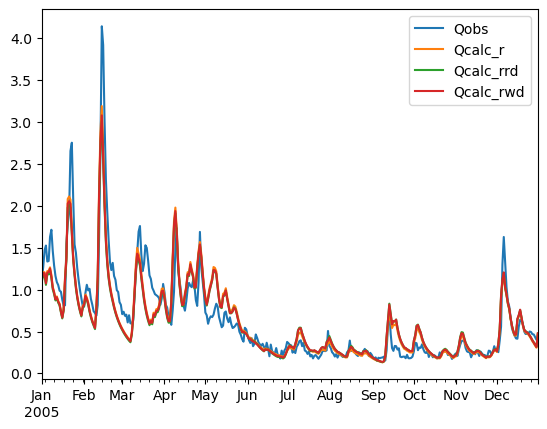

In [287]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DEBU1959"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

<Axes: >

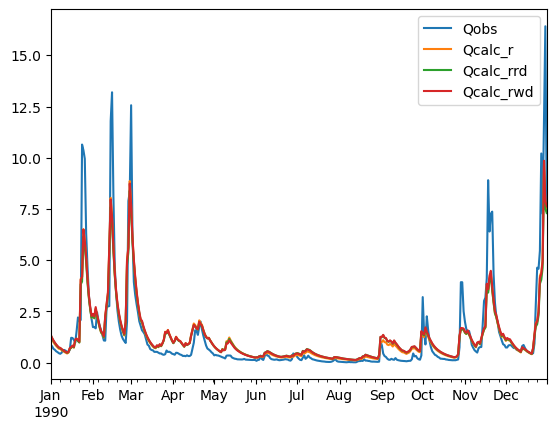

In [288]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2006"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1990"].plot()

<Axes: >

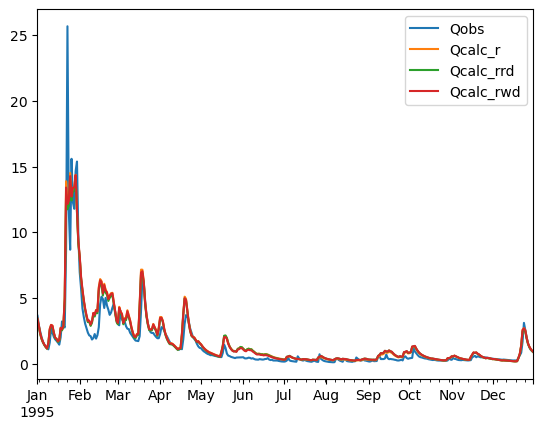

In [289]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2018"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1995"].plot()

<Axes: >

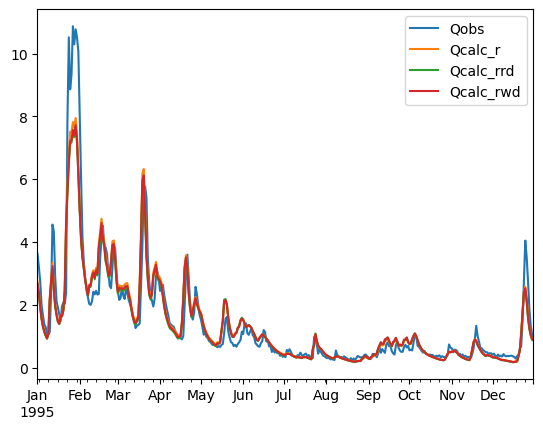

In [290]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DEBU1959"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1995"].plot()

<Axes: >

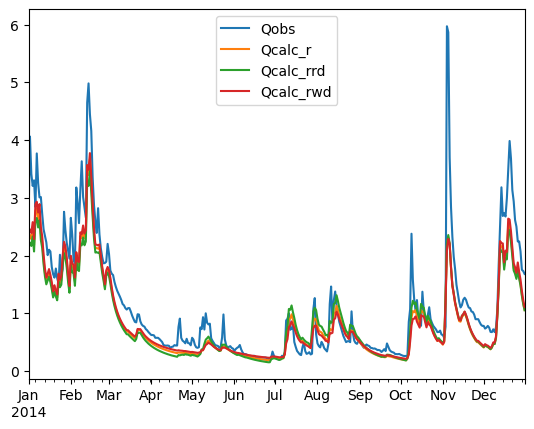

In [291]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

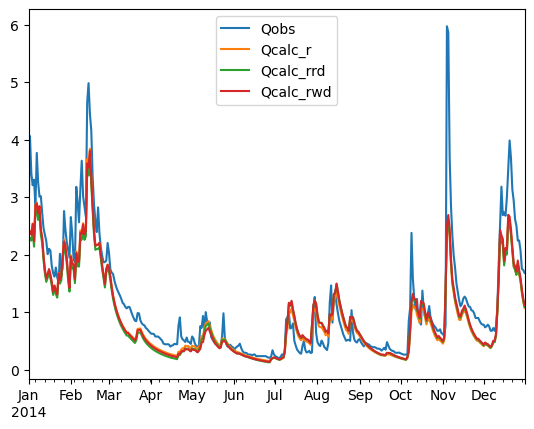

In [292]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

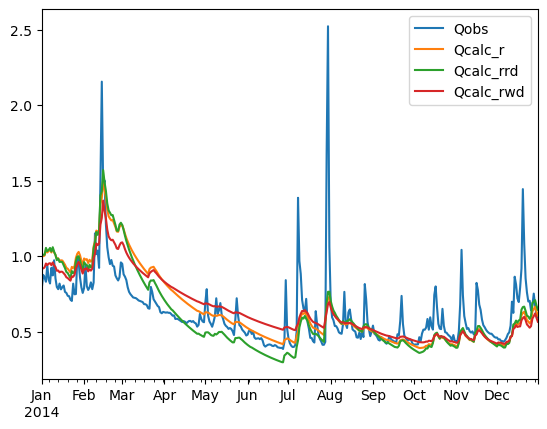

In [293]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2013"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c2[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c2[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

In [1]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="BEWA0066"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

NameError: name 'pd' is not defined

<Axes: >

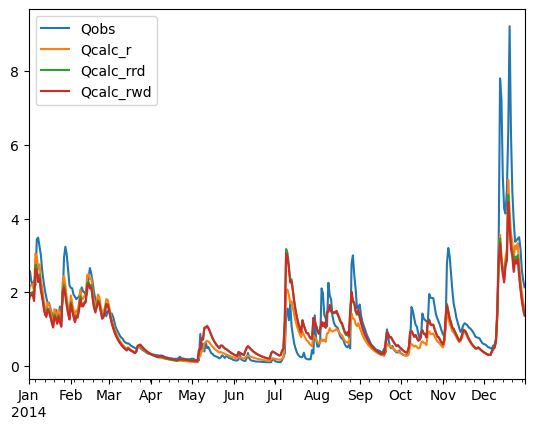

In [101]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="BEWA0066"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

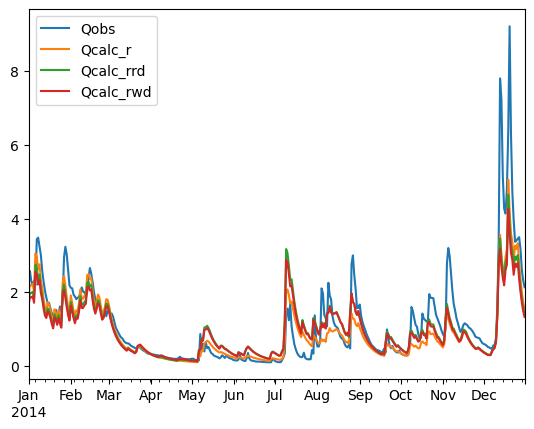

In [74]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="BEWA0066"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

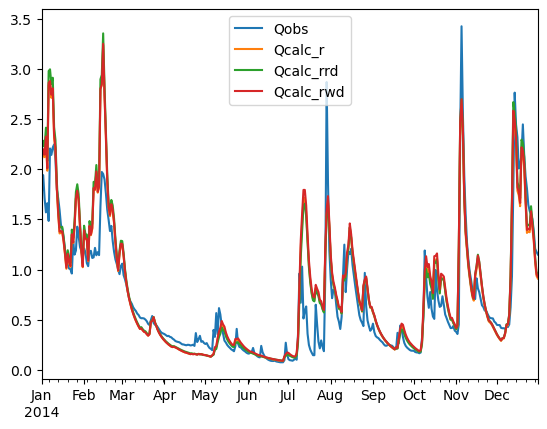

In [76]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2030"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

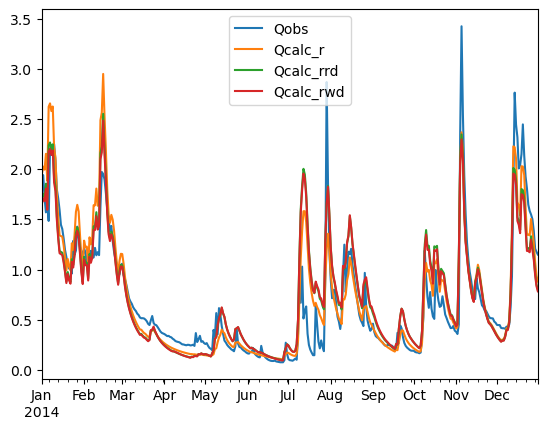

In [102]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2030"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

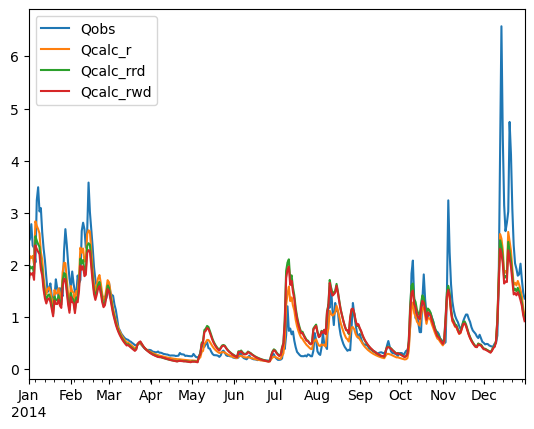

In [103]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

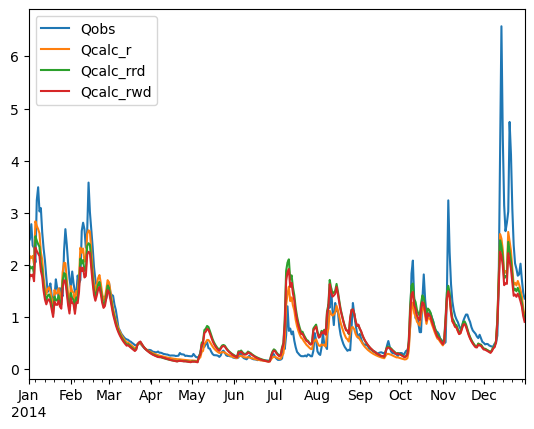

In [64]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

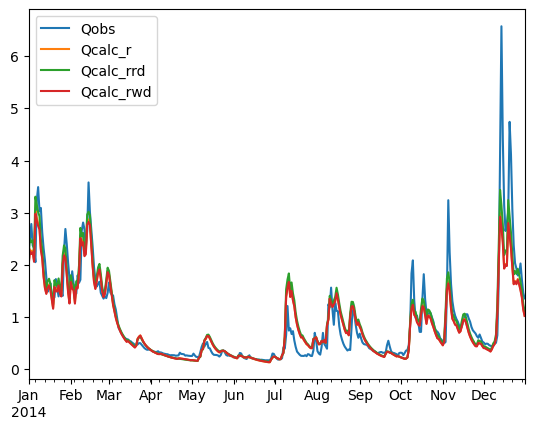

In [104]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

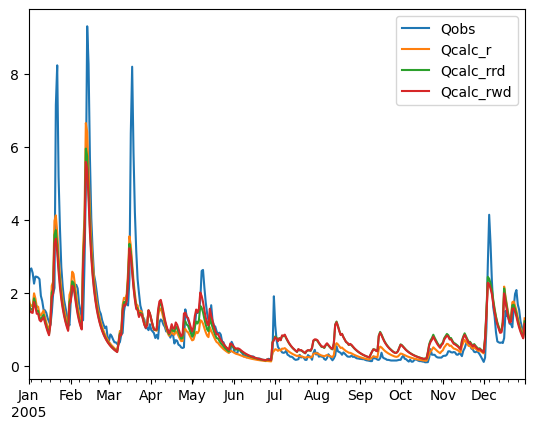

In [105]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000019"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

In [130]:
data_diff_val_complete

,nse,nse_rg,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,...,qmean_rd1,qmean_wd1,slope_obs,slope_r1,slope_rd1,slope_wd1,hfd_obs,hfd_r1,hfd_rd1,hfd_wd1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.028968,0.042789,0.835661,0.806693,0.792872,NaN,NaN,NaN,0.515742,0.552411,...,1.313855,1.293362,3.400558,3.069442,2.552401,2.511086,126.294118,130.235294,135.058824,136.411765
BEWA0067,0.022275,0.032829,0.785181,0.762906,0.752353,NaN,NaN,NaN,0.446878,0.538522,...,1.351120,1.357499,3.527884,3.114616,2.567979,2.513032,123.437500,130.062500,136.937500,138.187500
BEWA0106,0.043972,0.036802,0.756730,0.712759,0.719928,NaN,NaN,NaN,0.496805,0.550333,...,1.143150,1.087865,4.063631,3.027709,2.632144,2.659078,127.000000,131.913043,134.000000,136.086957
BEWA0107,0.064421,0.069559,0.740464,0.676042,0.670904,NaN,NaN,NaN,0.565063,0.537963,...,1.501118,1.490868,3.418299,3.059090,2.704510,2.720843,133.588235,134.764706,138.294118,140.647059
BEWA0119,0.023757,0.041217,0.811970,0.788213,0.770753,NaN,NaN,NaN,0.508101,0.546757,...,1.373926,1.378749,3.336434,3.063621,2.644835,2.630493,123.266667,130.266667,134.066667,134.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.080991,0.095122,0.819813,0.738823,0.724691,NaN,NaN,NaN,0.516853,0.551345,...,1.036090,0.942015,4.331634,2.995448,2.293951,2.102594,121.769231,124.384615,129.923077,136.461538
LU000016,-0.048770,-0.039076,0.636273,0.685043,0.675349,NaN,NaN,NaN,0.564940,0.522122,...,0.708363,0.682674,2.005883,3.044009,2.486333,2.325824,133.615385,126.000000,133.692308,137.230769
LU000017,0.024070,0.045542,0.860150,0.836079,0.814607,NaN,NaN,NaN,0.572433,0.591535,...,0.873796,0.832764,2.459555,2.591746,2.072990,1.989772,127.307692,129.461538,135.230769,138.615385


In [133]:
data_diff_cal_complete

,nse,nse_rg,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,...,qmean_rd1,qmean_wd1,slope_obs,slope_r1,slope_rd1,slope_wd1,hfd_obs,hfd_r1,hfd_rd1,hfd_wd1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.003207,-0.006045,0.839831,0.836625,0.845876,NaN,NaN,NaN,0.515742,0.553206,...,1.370934,1.385859,3.400558,2.848416,2.746327,2.912803,126.294118,133.764706,132.529412,130.647059
BEWA0067,-0.005940,-0.023156,0.796970,0.802911,0.820127,NaN,NaN,NaN,0.446878,0.537183,...,1.437194,1.501458,3.527884,2.830461,2.781776,2.966153,123.437500,135.687500,133.562500,129.187500
BEWA0106,0.027354,0.014443,0.770358,0.743004,0.755916,NaN,NaN,NaN,0.496805,0.551697,...,1.133911,1.057350,4.063631,2.917710,2.705387,2.809485,127.000000,132.608696,132.739130,136.739130
BEWA0107,0.042192,0.025044,0.733016,0.690823,0.707971,NaN,NaN,NaN,0.565063,0.540640,...,1.507008,1.502224,3.418299,2.918635,2.765452,2.801843,133.588235,138.000000,136.411765,134.647059
BEWA0119,0.008601,0.008337,0.827236,0.818634,0.818899,NaN,NaN,NaN,0.508101,0.547025,...,1.376714,1.384771,3.336434,2.895043,2.709969,2.829473,123.266667,132.800000,132.200000,131.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.018347,-0.050499,0.767700,0.749353,0.818199,NaN,NaN,NaN,0.516853,0.546272,...,1.137571,1.072076,4.331634,2.596426,2.693903,3.153739,121.769231,131.230769,126.538462,130.153846
LU000016,-0.001026,0.094378,0.701424,0.702450,0.607046,NaN,NaN,NaN,0.564940,0.561432,...,0.755069,0.693094,2.005883,2.661788,2.736857,3.395220,133.615385,133.230769,132.000000,139.230769
LU000017,-0.004688,-0.000871,0.858641,0.863329,0.859511,NaN,NaN,NaN,0.572433,0.594660,...,0.953249,0.916460,2.459555,2.331304,2.385455,2.628948,127.307692,135.230769,132.230769,135.615385


<Axes: >

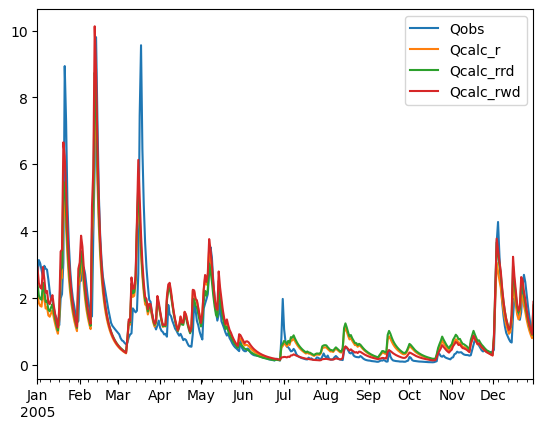

In [140]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="BEWA0066"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_cal[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_cal[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

<Axes: >

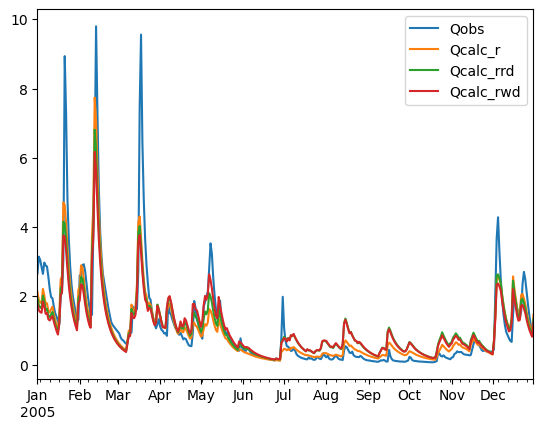

In [135]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="BEWA0066"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val_c[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

<Axes: >

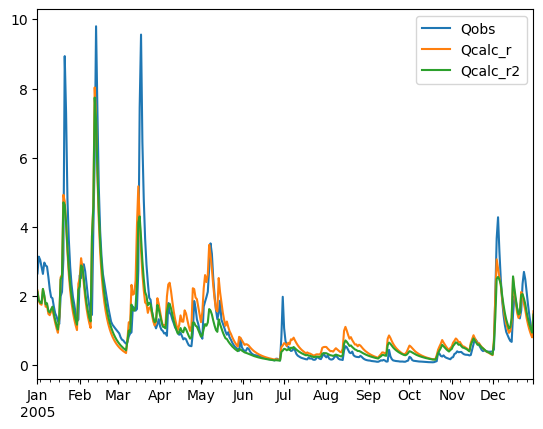

In [142]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="BEWA0066"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_cal[gauge_id][0]
Qtimeseries["Qcalc_r2"] = output_regional_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005"].plot()

#### We see that for space validation the results are clearly superior for calculating the peaks well for RD or WD rather than with regional only. For sapece-time validation, regional seems to remains as it was, but RD and WD clearly degrades their respective performance. 

In [170]:
data_diff_cal[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]] = estreams_attributes[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]]
data_diff_cal[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]] = estreams_attributes[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]]
data_diff_cal[['lat_snap', 'lon_snap']] = estreams_attributes[['lat_snap', 'lon_snap']]
data_diff_cal[['area']] = estreams_attributes[['area_estreams']]

data_diff_cal

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,bfi_g1,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,lat_snap,lon_snap,area
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.034058,0.310443,0.826402,0.860460,0.515958,0.823303,0.883596,0.138918,0.511429,0.557320,...,0.803718,3.0,3.0,94.0,75.0,25.0,0.0,50.188258,6.151802,357.829
BEWA0067,-0.019116,0.267704,0.776418,0.795534,0.508714,0.765821,0.795083,0.047242,0.443161,0.540013,...,0.760583,2.0,0.0,98.0,64.0,36.0,0.0,50.289277,6.263467,101.033
BEWA0106,-0.047748,0.465526,0.738859,0.786607,0.273333,NaN,NaN,NaN,0.473400,0.560178,...,0.846723,0.0,0.0,100.0,100.0,0.0,0.0,50.196522,6.150669,58.549
BEWA0107,-0.038995,0.380173,0.723577,0.762572,0.343404,NaN,NaN,NaN,0.565604,0.553497,...,0.832013,4.0,15.0,81.0,100.0,0.0,0.0,50.235014,6.153292,77.098
BEWA0119,-0.027736,0.313667,0.811971,0.839707,0.498304,NaN,NaN,NaN,0.503286,0.554247,...,0.793015,3.0,3.0,94.0,75.0,25.0,0.0,50.141935,6.141814,395.486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.078411,0.401203,0.753774,0.832185,0.352571,0.778332,0.853968,-0.200624,0.517760,0.555506,...,0.846011,2.0,0.0,98.0,100.0,0.0,0.0,49.895421,6.091178,946.519
LU000016,0.114346,0.128390,0.688915,0.574570,0.560526,0.497113,0.071846,-0.166926,0.563590,0.562215,...,0.552001,14.0,86.0,0.0,0.0,100.0,0.0,49.620647,6.132266,387.289
LU000017,0.003912,0.101954,0.852524,0.848612,0.750569,0.871139,0.857222,0.680423,0.574924,0.598715,...,0.727089,19.0,31.0,50.0,41.0,59.0,0.0,49.785883,6.509851,4255.524


In [171]:
data_diff_cal[data_diff_cal.nse_r1<0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,bfi_g1,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,lat_snap,lon_snap,area
basin,,,,,,,,,,,,,,,,,,,,,
FR000144,-0.161702,-0.107624,-0.338022,-0.176320,-0.230398,NaN,NaN,NaN,0.681845,0.768781,...,0.804764,92.0,0.0,8.0,83.0,5.0,12.0,48.416320,6.877879,117.784
FR000185,0.175389,0.078666,0.380050,0.204661,0.301385,NaN,NaN,NaN,0.558059,0.747527,...,0.790320,75.0,23.0,2.0,71.0,27.0,2.0,48.680322,7.014472,188.492
FR003250,-0.062410,-0.089830,0.201436,0.263847,0.291266,NaN,NaN,NaN,0.683473,0.540899,...,0.585286,4.0,0.0,96.0,0.0,6.0,94.0,48.184730,7.002529,67.143
FR003259,0.141190,0.013033,0.311947,0.170757,0.298914,NaN,NaN,NaN,0.587749,0.710226,...,0.670856,66.0,34.0,0.0,35.0,65.0,0.0,48.324169,6.645964,64.746
FR003280,-0.054395,-0.049826,0.393840,0.448235,0.443666,NaN,NaN,NaN,0.687017,0.523113,...,0.550688,0.0,100.0,0.0,0.0,100.0,0.0,49.246953,5.933378,74.738
FR003288,0.042357,0.177624,0.448982,0.406625,0.271358,NaN,NaN,NaN,0.586159,0.624539,...,0.550658,29.0,71.0,0.0,0.0,100.0,0.0,49.391885,6.272360,108.785
FR003303,-0.045123,-0.015703,-0.557843,-0.512720,-0.542140,-2.193359,-2.774296,-2.535956,0.794509,0.795206,...,0.845255,98.0,2.0,0.0,96.0,4.0,0.0,49.127103,7.472093,95.212
FR003306,-0.262914,-0.075006,-0.472334,-0.209420,-0.397328,NaN,NaN,NaN,0.749280,0.769845,...,0.809703,94.0,6.0,0.0,91.0,9.0,0.0,49.225799,6.688894,58.148


In [172]:
data_diff_cal[data_diff_cal.nse_g1<0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,bfi_g1,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,lat_snap,lon_snap,area
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0106,-0.047748,0.465526,0.738859,0.786607,0.273333,NaN,NaN,NaN,0.473400,0.560178,...,0.846723,0.0,0.0,100.0,100.0,0.0,0.0,50.196522,6.150669,58.549
BEWA0107,-0.038995,0.380173,0.723577,0.762572,0.343404,NaN,NaN,NaN,0.565604,0.553497,...,0.832013,4.0,15.0,81.0,100.0,0.0,0.0,50.235014,6.153292,77.098
BEWA0119,-0.027736,0.313667,0.811971,0.839707,0.498304,NaN,NaN,NaN,0.503286,0.554247,...,0.793015,3.0,3.0,94.0,75.0,25.0,0.0,50.141935,6.141814,395.486
FR000144,-0.161702,-0.107624,-0.338022,-0.176320,-0.230398,NaN,NaN,NaN,0.681845,0.768781,...,0.804764,92.0,0.0,8.0,83.0,5.0,12.0,48.416320,6.877879,117.784
FR000174,0.058445,0.043990,0.543822,0.485377,0.499832,NaN,NaN,NaN,0.412715,0.520488,...,0.548412,0.0,100.0,0.0,1.0,99.0,0.0,49.098776,5.837081,132.249
FR000185,0.175389,0.078666,0.380050,0.204661,0.301385,NaN,NaN,NaN,0.558059,0.747527,...,0.790320,75.0,23.0,2.0,71.0,27.0,2.0,48.680322,7.014472,188.492
FR003250,-0.062410,-0.089830,0.201436,0.263847,0.291266,NaN,NaN,NaN,0.683473,0.540899,...,0.585286,4.0,0.0,96.0,0.0,6.0,94.0,48.184730,7.002529,67.143
FR003259,0.141190,0.013033,0.311947,0.170757,0.298914,NaN,NaN,NaN,0.587749,0.710226,...,0.670856,66.0,34.0,0.0,35.0,65.0,0.0,48.324169,6.645964,64.746
FR003280,-0.054395,-0.049826,0.393840,0.448235,0.443666,NaN,NaN,NaN,0.687017,0.523113,...,0.550688,0.0,100.0,0.0,0.0,100.0,0.0,49.246953,5.933378,74.738


In [173]:
data_diff_cal.corr()

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,bfi_g1,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,lat_snap,lon_snap,area
nse,1.000000,0.010238,0.201719,-0.173474,0.195446,-0.115490,-0.475158,-0.128136,0.030386,0.334681,...,-0.133968,0.286823,0.184957,-0.360484,-0.174870,0.285378,-0.223633,0.031748,0.079077,-0.083223
nse_rg,0.010238,1.000000,0.242853,0.240339,-0.263193,0.136068,0.175018,-0.415036,-0.280035,-0.179718,...,0.538962,-0.283654,-0.272276,0.440365,0.573869,-0.345169,-0.349138,0.588110,-0.353708,-0.111144
nse_r1,0.201719,0.242853,1.000000,0.929601,0.871945,0.976431,0.894321,0.763905,-0.410996,-0.380854,...,-0.136763,-0.478424,0.100854,0.217116,-0.185111,0.180250,-0.013585,0.173296,-0.198658,0.198964
nse_c1,-0.173474,0.240339,0.929601,1.000000,0.803200,0.903739,0.978582,0.722465,-0.424694,-0.508893,...,-0.087104,-0.588992,0.031809,0.353963,-0.120326,0.073854,0.070494,0.162304,-0.229509,0.231377
nse_g1,0.195446,-0.263193,0.871945,0.803200,1.000000,0.807603,0.711279,0.925834,-0.267404,-0.288059,...,-0.408036,-0.332637,0.237723,-0.006334,-0.473736,0.353473,0.162704,-0.124482,-0.019047,0.253969
nse_bfi_r1,-0.115490,0.136068,0.976431,0.903739,0.807603,1.000000,0.911266,0.793382,-0.512003,-0.501538,...,-0.123628,-0.571420,0.037422,0.307283,-0.154993,0.115827,0.124338,0.135433,-0.300159,0.146371
nse_bfi_c1,-0.475158,0.175018,0.894321,0.978582,0.711279,0.911266,1.000000,0.733817,-0.510394,-0.573303,...,-0.026782,-0.639918,-0.093089,0.453713,-0.054671,0.005850,0.159222,0.140643,-0.238268,0.164519
nse_bfi_g1,-0.128136,-0.415036,0.763905,0.722465,0.925834,0.793382,0.733817,1.000000,-0.250108,-0.226065,...,-0.266103,-0.314109,0.143742,0.068919,-0.342578,0.253772,0.282197,-0.111760,0.082287,0.216870
bfi_obs,0.030386,-0.280035,-0.410996,-0.424694,-0.267404,-0.512003,-0.510394,-0.250108,1.000000,0.651260,...,0.333839,0.700842,-0.203832,-0.265412,0.313916,-0.358580,0.119936,-0.288938,0.450806,0.127213
bfi_r1,0.334681,-0.179718,-0.380854,-0.508893,-0.288059,-0.501538,-0.573303,-0.226065,0.651260,1.000000,...,0.481614,0.943624,-0.169143,-0.456174,0.414800,-0.244094,-0.262249,-0.112010,0.499743,0.081608


In [29]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()


output_continental_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1, perm_areas = perm_areascontinental)
output_regional_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas = perm_areas)
output_global_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas = perm_areasglobal)

nse_results_val_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_2)
nse_results_val_c_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_continental_2)
nse_results_val_g_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_global_2)

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_7804\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_7804\2733552632.py:450: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\mi

In [30]:
data_diff_val = pd.DataFrame(data=nse_results_val_r_1_100.nse - nse_results_val_c_1_100.nse)
data_diff_val["nse_rg"] = nse_results_val_r_1_100.nse - nse_results_val_g_1_100.nse

data_diff_val.index = nse_results_val_c_1_100.basin

data_diff_val = data_diff_val.loc[~data_diff_val.index.isin(list_cal)]

data_diff_val["nse_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse
data_diff_val["nse_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).nse
data_diff_val["nse_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse

data_diff_val["nse_bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse_value_bfi

data_diff_val["bfi_obs"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_val["bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).bfi_sim

data_diff_val = data_diff_val[data_diff_val.nse_r1 > -10.0]
data_diff_val

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,bfi_c1,bfi_g1
basin,,,,,,,,,,,,
BEWA0066,-0.027887,0.292720,0.818833,0.846719,0.526113,NaN,NaN,NaN,0.524659,0.552303,0.566561,0.786703
BEWA0067,-0.030009,0.270157,0.786773,0.816782,0.516617,NaN,NaN,NaN,0.469727,0.547326,0.563061,0.737641
BEWA0106,-0.062011,0.345959,0.718509,0.780521,0.372550,NaN,NaN,NaN,0.506445,0.539109,0.560652,0.821925
BEWA0107,-0.013761,0.226957,0.719498,0.733259,0.492541,NaN,NaN,NaN,0.557155,0.522635,0.533596,0.772290
BEWA0119,-0.027527,0.272161,0.784596,0.812124,0.512435,NaN,NaN,NaN,0.513078,0.538153,0.553451,0.757345
...,...,...,...,...,...,...,...,...,...,...,...,...
FR003300,0.044509,0.048603,0.505983,0.461474,0.457380,0.101674,0.030655,-0.036429,0.526066,0.651515,0.649514,0.674813
FR003302,0.052544,0.049895,0.789622,0.737078,0.739727,NaN,NaN,NaN,0.525576,0.595702,0.633415,0.620531
FR003303,-0.253899,-0.114652,-0.586202,-0.332303,-0.471551,NaN,NaN,NaN,0.804400,0.764694,0.866724,0.816654


<Axes: xlabel='basin'>

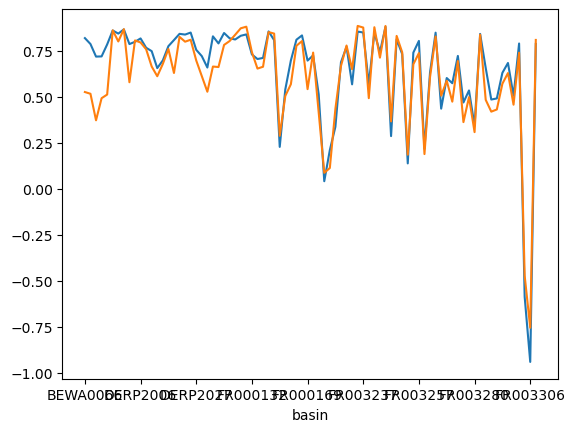

In [176]:
data_diff_val.nse_r1.plot()
data_diff_val.nse_g1.plot()

(0.2, 1.0)

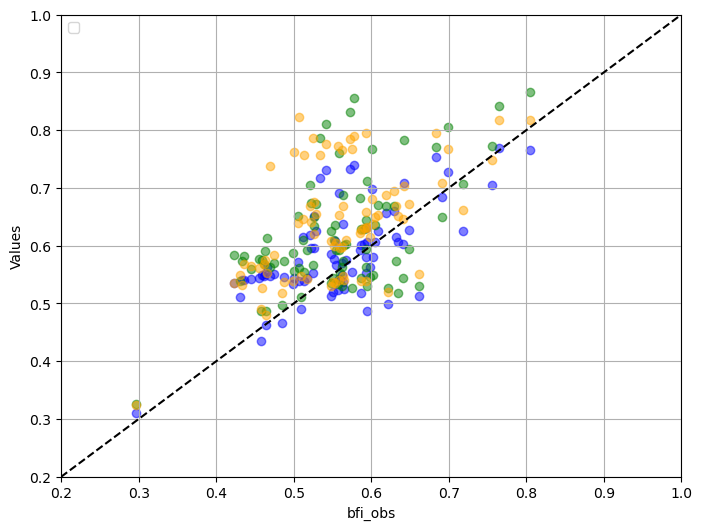

In [177]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_c1"], color='green', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_g1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])

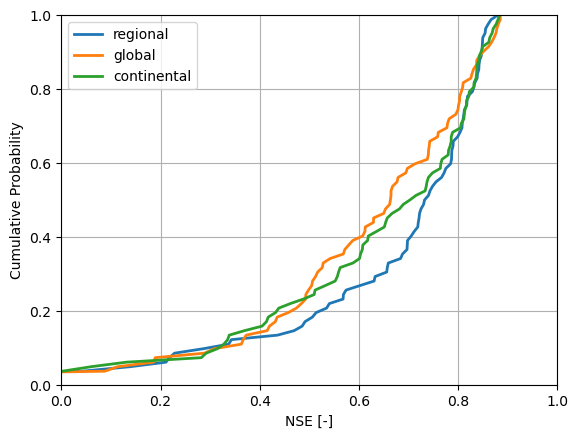

In [178]:


# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)


# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

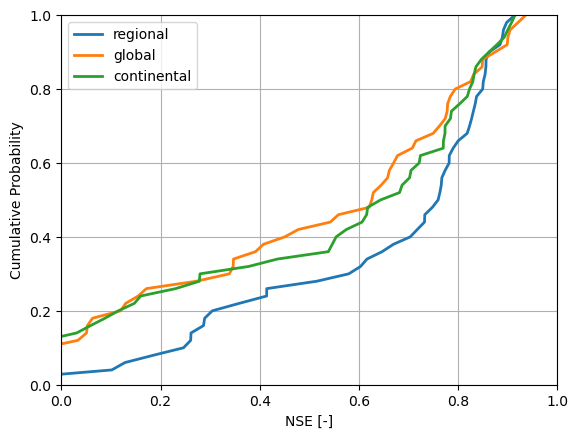

In [179]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)


# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [32]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()


output_regional_wd_val = run_model_superflexpy_wd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_WD_1, perm_areas = perm_areas, waterdeficit_mean = waterdeficit_mean)
output_regional_rd_val = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_RD_1, perm_areas = perm_areas, waterdeficit_mean = rootdepth_mean)
output_regional_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas = perm_areas)
#output_global_rd_val = run_model_superflexpy_wd_rd(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_RD_1, perm_areas = perm_areasglobal, waterdeficit_mean = rootdepth_mean)

In [33]:
nse_results_val_r_1_100_wd = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_wd_val)
nse_results_val_r_1_100_rd = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_rd_val)
nse_results_val_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_val)
#nse_results_cal_g_1_100_rd = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_global_rd_val)

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_7804\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_7804\2733552632.py:450: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\mi

In [244]:
nse_results_val_r_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\521990233.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.179721,0.007369,-0.273303,0.052353,0.940026
q_mean_obs,0.179721,1.000000,0.916750,-0.030378,-0.257507,0.269699
q_mean_calc,0.007369,0.916750,1.000000,-0.042306,-0.244138,0.263379
bfi_obs,-0.273303,-0.030378,-0.042306,1.000000,0.667274,-0.441137
bfi_sim,0.052353,-0.257507,-0.244138,0.667274,1.000000,-0.470206
nse_value_bfi,0.940026,0.269699,0.263379,-0.441137,-0.470206,1.000000


In [243]:
nse_results_val_r_1_100_rd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\3420530449.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100_rd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.179122,-0.020309,-0.248872,0.079519,0.897603
q_mean_obs,0.179122,1.000000,0.913201,-0.030378,-0.195888,0.348054
q_mean_calc,-0.020309,0.913201,1.000000,-0.044067,-0.188652,0.348453
bfi_obs,-0.248872,-0.030378,-0.044067,1.000000,0.668968,-0.362228
bfi_sim,0.079519,-0.195888,-0.188652,0.668968,1.000000,-0.470102
nse_value_bfi,0.897603,0.348054,0.348453,-0.362228,-0.470102,1.000000


In [242]:
nse_results_val_r_1_100_wd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8240\3948472811.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100_wd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.181888,-0.001501,-0.266865,0.109196,0.924621
q_mean_obs,0.181888,1.000000,0.909987,-0.030378,-0.656691,0.301352
q_mean_calc,-0.001501,0.909987,1.000000,-0.036929,-0.713737,0.280281
bfi_obs,-0.266865,-0.030378,-0.036929,1.000000,0.375799,-0.299670
bfi_sim,0.109196,-0.656691,-0.713737,0.375799,1.000000,-0.464909
nse_value_bfi,0.924621,0.301352,0.280281,-0.299670,-0.464909,1.000000


In [245]:
nse_results_val_r_1_100[nse_results_val_r_1_100.nse > 0.85]


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
6,BundespegelPerl,DEBU1956,0.860349,1.079179,1.212445,0.586521,0.600863,0.889093
8,BundespegelTrierUp,DEBU1958,0.860558,0.979012,1.134230,0.593301,0.605634,0.848794
9,BundespegelCochem,DEBU1959,0.866199,1.038761,1.115567,0.604452,0.606576,0.897588
22,Hentern,DERP2017,0.870735,1.395562,1.288507,0.577916,0.586500,0.903583
41,A5500610,FR000140,0.855259,1.530514,1.749048,0.554309,0.567070,NaN
58,La Vologne Ã ChenimÃ©nil,FR003236,0.854176,2.306219,2.205165,0.601937,0.580139,0.884328
63,La Moselle Ã Toul,FR003249,0.879900,1.571429,1.659267,0.567660,0.575692,0.914033
74,La Moselle Ã Custines,FR003265,0.900127,1.422836,1.395776,0.591212,0.611798,0.934816


In [247]:
nse_results_val_r_1_100_wd[nse_results_val_r_1_100_wd.nse > 0.85]


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
22,Hentern,DERP2017,0.858786,1.395562,1.327916,0.577916,0.597246,0.878294
63,La Moselle Ã Toul,FR003249,0.850662,1.571429,1.745111,0.567660,0.586512,0.854238
74,La Moselle Ã Custines,FR003265,0.882442,1.422836,1.459797,0.591212,0.615866,0.909752


In [248]:
nse_results_val_r_1_100_rd[nse_results_val_r_1_100_rd.nse > 0.85]


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
6,BundespegelPerl,DEBU1956,0.867679,1.079179,1.255430,0.586521,0.623633,0.858107
7,BundespegelFremersdorf,DEBU1957,0.853403,0.876168,0.980890,0.608043,0.654052,0.731655
8,BundespegelTrierUp,DEBU1958,0.860260,0.979012,1.181399,0.593301,0.622321,0.811103
9,BundespegelCochem,DEBU1959,0.874909,1.038761,1.161963,0.604452,0.622478,0.888446
22,Hentern,DERP2017,0.892641,1.395562,1.368299,0.577916,0.600451,0.929865
24,Juenkerath,DERP2021,0.870837,1.453947,1.529250,0.462274,0.530819,0.878720
36,A4050620,FR000125,0.857180,3.826654,3.411589,0.484163,0.465563,0.878094
37,A4200630,FR000128,0.855743,3.216753,2.960241,0.509667,0.493914,0.893937
63,La Moselle Ã Toul,FR003249,0.874277,1.571429,1.743054,0.567660,0.600471,0.882059
74,La Moselle Ã Custines,FR003265,0.898678,1.422836,1.456246,0.591212,0.645551,0.912683


In [34]:
data_diff_val = pd.DataFrame(data=nse_results_val_r_1_100_rd.nse - nse_results_val_r_1_100.nse)
data_diff_val["nse_rwd"] = nse_results_val_r_1_100_wd.nse - nse_results_val_r_1_100.nse

data_diff_val.index = nse_results_val_r_1_100.basin

data_diff_val = data_diff_val.loc[~data_diff_val.index.isin(list_cal)]

data_diff_val["nse_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse
data_diff_val["nse_rd1"] = nse_results_val_r_1_100_rd.set_index("basin", inplace = False).nse
data_diff_val["nse_wd1"] = nse_results_val_r_1_100_wd.set_index("basin", inplace = False).nse

data_diff_val["nse_bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_rd1"] = nse_results_val_r_1_100_rd.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_wd1"] = nse_results_val_r_1_100_wd.set_index("basin", inplace = False).nse_value_bfi

data_diff_val["bfi_obs"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_val["bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_rd1"] = nse_results_val_r_1_100_rd.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_wd1"] = nse_results_val_r_1_100_wd.set_index("basin", inplace = False).bfi_sim

data_diff_val = data_diff_val[data_diff_val.nse_r1 > -10.0]
data_diff_val

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1
basin,,,,,,,,,,,,
BEWA0066,-0.010863,-0.032709,0.818833,0.807970,0.786124,NaN,NaN,NaN,0.524659,0.552303,0.532573,0.566430
BEWA0067,0.044448,-0.002998,0.786773,0.831221,0.783776,NaN,NaN,NaN,0.469727,0.547326,0.532882,0.558599
BEWA0106,-0.008568,-0.042722,0.718509,0.709941,0.675787,NaN,NaN,NaN,0.506445,0.539109,0.507066,0.556166
BEWA0107,-0.120841,-0.044368,0.719498,0.598657,0.675130,NaN,NaN,NaN,0.557155,0.522635,0.506235,0.543420
BEWA0119,-0.017585,-0.027685,0.784596,0.767012,0.756911,NaN,NaN,NaN,0.513078,0.538153,0.517465,0.550190
...,...,...,...,...,...,...,...,...,...,...,...,...
FR003300,-0.005831,-0.037039,0.505983,0.500152,0.468944,0.101674,-0.071019,0.016227,0.526066,0.651515,0.691684,0.670978
FR003302,0.003531,-0.072840,0.789622,0.793154,0.716782,NaN,NaN,NaN,0.525576,0.595702,0.614696,0.651730
FR003303,0.312638,-0.115531,-0.586202,-0.273564,-0.701733,NaN,NaN,NaN,0.804400,0.764694,0.885353,0.678150


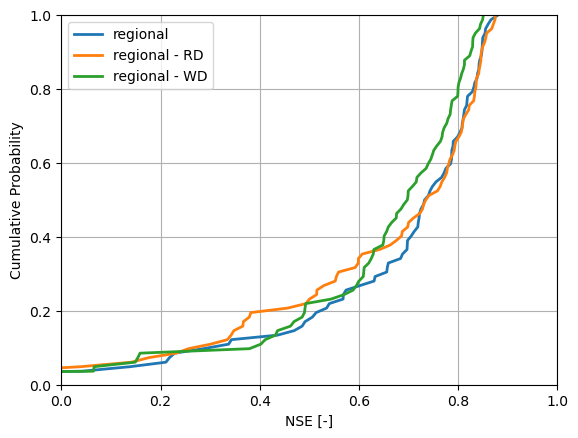

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_rd1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="regional - RD", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="regional - WD", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


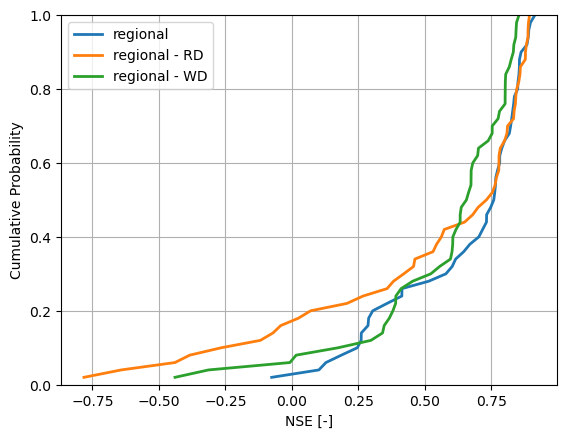

In [272]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_bfi_rd1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_bfi_wd1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="regional - RD", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="regional - WD", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
#plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [268]:
data_diff_val[data_diff_val.nse_r1>0.85]

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1
basin,,,,,,,,,,,,
DEBU1956,0.007330,-0.030404,0.860349,0.867679,0.829946,0.889093,0.858107,0.803002,0.586521,0.600863,0.623633,0.629518
DEBU1959,0.008710,-0.016963,0.866199,0.874909,0.849236,0.897588,0.888446,0.843388,0.604452,0.606576,0.622478,0.638333
FR000140,-0.019601,-0.042622,0.855259,0.835659,0.812637,NaN,NaN,NaN,0.554309,0.567070,0.593125,0.570887
FR003236,-0.020640,-0.028344,0.854176,0.833536,0.825832,0.884328,0.840934,0.833078,0.601937,0.580139,0.623398,0.539996
FR003249,-0.005623,-0.029238,0.879900,0.874277,0.850662,0.914033,0.882059,0.854238,0.567660,0.575692,0.600471,0.586512


In [43]:
data_diff_val["area"] = network_estreams["area_estreams"]

In [44]:
data_diff_val[data_diff_val.nse_rd1>0.7]

,nse,nse_rwd,nse_r1,nse_rd1,nse_wd1,nse_bfi_r1,nse_bfi_rd1,nse_bfi_wd1,bfi_obs,bfi_r1,bfi_rd1,bfi_wd1,area
basin,,,,,,,,,,,,,
BEWA0066,-0.010863,-0.032709,0.818833,0.807970,0.786124,NaN,NaN,NaN,0.524659,0.552303,0.532573,0.566430,357.829
BEWA0067,0.044448,-0.002998,0.786773,0.831221,0.783776,NaN,NaN,NaN,0.469727,0.547326,0.532882,0.558599,101.033
BEWA0106,-0.008568,-0.042722,0.718509,0.709941,0.675787,NaN,NaN,NaN,0.506445,0.539109,0.507066,0.556166,58.549
BEWA0119,-0.017585,-0.027685,0.784596,0.767012,0.756911,NaN,NaN,NaN,0.513078,0.538153,0.517465,0.550190,395.486
DEBU1956,0.007330,-0.030404,0.860349,0.867679,0.829946,0.889093,0.858107,0.803002,0.586521,0.600863,0.623633,0.629518,11500.000
DEBU1957,0.010098,-0.032950,0.843304,0.853403,0.810354,0.732072,0.731655,0.674160,0.608043,0.624932,0.654052,0.661999,6970.000
DEBU1959,0.008710,-0.016963,0.866199,0.874909,0.849236,0.897588,0.888446,0.843388,0.604452,0.606576,0.622478,0.638333,27100.000
DERP2004,-0.009865,-0.047150,0.786498,0.776634,0.739349,0.763064,0.769311,0.633147,0.500469,0.543522,0.517331,0.559187,615.000
DERP2005,0.022471,-0.047987,0.798761,0.821233,0.750775,0.759450,0.809036,0.596642,0.444113,0.541454,0.505981,0.570428,125.000


<Axes: >

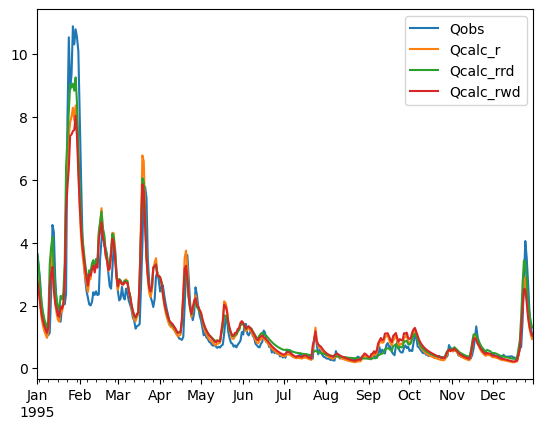

In [37]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DEBU1959"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1995"].plot()

<Axes: >

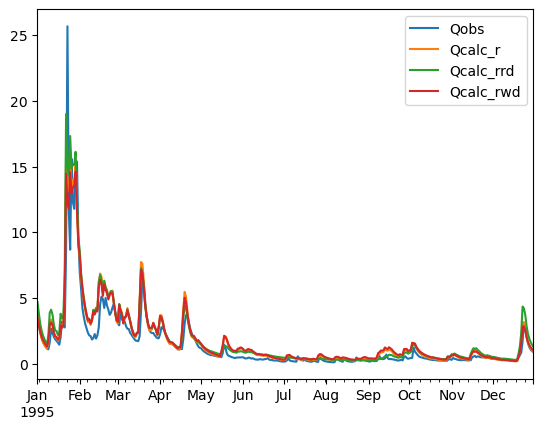

In [259]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DERP2018"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1995"].plot()

<Axes: >

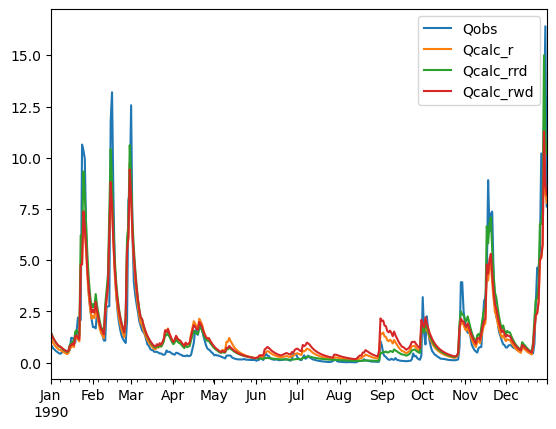

In [46]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DERP2006"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1990"].plot()

<Axes: >

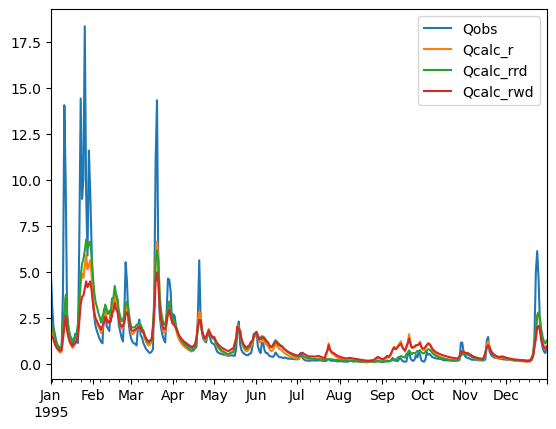

In [42]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="FR003246"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val[gauge_id][0]
Qtimeseries["Qcalc_rrd"] = output_regional_rd_val[gauge_id][0]
Qtimeseries["Qcalc_rwd"] = output_regional_wd_val[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1995"].plot()

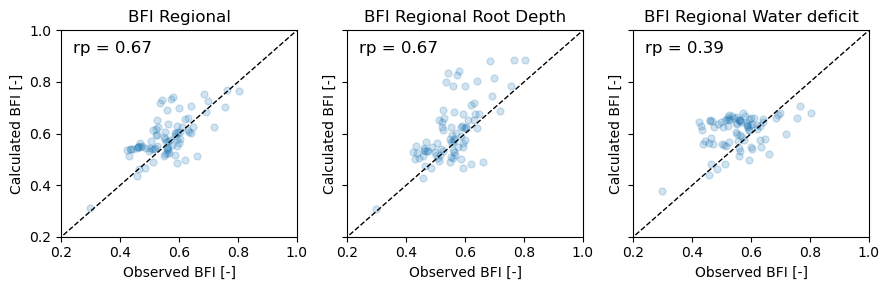

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_rd1', 'bfi_wd1']
titles = ['BFI Regional', 'BFI Regional Root Depth', 'BFI Regional Water deficit']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val["bfi_obs"]
    y = data_diff_val[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

In [70]:
inputstimesies = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DERP2013"

inputstimesies["P"] = inputs[gauge_id][0]
inputstimesies["PET"] = inputs[gauge_id][2]


In [71]:
# For example, using mean values clearly for yearly aggregation:
inputstimesies_yearly = inputstimesies.resample("Y").sum()
inputstimesies_yearly

,P,PET
1988-12-31,918.62,752.15
1989-12-31,761.00,806.74
1990-12-31,817.36,812.31
1991-12-31,599.90,790.63
1992-12-31,798.06,792.08
1993-12-31,851.49,774.63
1994-12-31,876.86,781.38
1995-12-31,1011.65,757.39
1996-12-31,692.02,734.46
1997-12-31,827.05,771.72


In [73]:
inputstimesies.to_csv("inputstimesies_yearly.csv")

In [51]:
waterdeficit_mean

{'BEWA0066': 289.8,
 'BEWA0067': 271.9,
 'BEWA0087': 331.1,
 'BEWA0106': 331.3,
 'BEWA0107': 287.8,
 'BEWA0119': 292.3,
 'DEBU1956': 471.7,
 'DEBU1957': 542.2,
 'DEBU1958': 464.6,
 'DEBU1959': 459.4,
 'DERP2003': 420.5,
 'DERP2004': 301.9,
 'DERP2005': 332.9,
 'DERP2006': 287.8,
 'DERP2007': 381.6,
 'DERP2008': 380.2,
 'DERP2010': 394.7,
 'DERP2011': 433.4,
 'DERP2013': 720.0,
 'DERP2014': 493.4,
 'DERP2015': 507.6,
 'DERP2016': 595.6,
 'DERP2017': 443.0,
 'DERP2018': 445.8,
 'DERP2021': 320.8,
 'DERP2022': 375.6,
 'DERP2023': 403.6,
 'DERP2024': 456.0,
 'DERP2027': 449.0,
 'DERP2028': 455.6,
 'DERP2029': 494.2,
 'DERP2030': 452.0,
 'DERP2031': 433.9,
 'DERP2033': 525.6,
 'DERP2036': 629.9,
 'FR000124': 193.8,
 'FR000125': 203.3,
 'FR000126': 206.4,
 'FR000127': 206.7,
 'FR000128': 237.0,
 'FR000132': 249.9,
 'FR000133': 278.0,
 'FR000134': 288.5,
 'FR000135': 336.2,
 'FR000136': 471.1,
 'FR000137': 461.6,
 'FR000138': 474.3,
 'FR000139': 474.3,
 'FR000140': 392.9,
 'FR000142': 291.8,


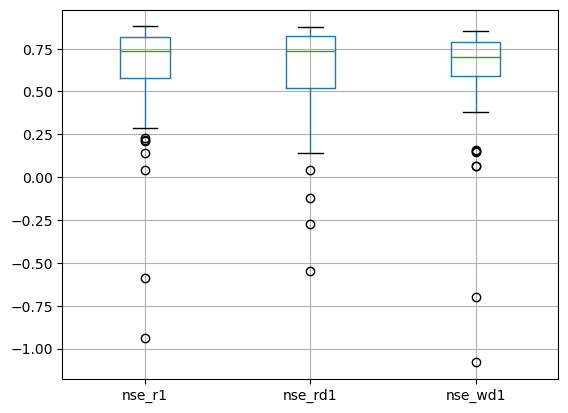

In [47]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_val[data_diff_val.nse_wd1 > -6].boxplot(column=["nse_r1","nse_rd1", "nse_wd1"])

# Show the plot
plt.show()


(0.2, 1.0)

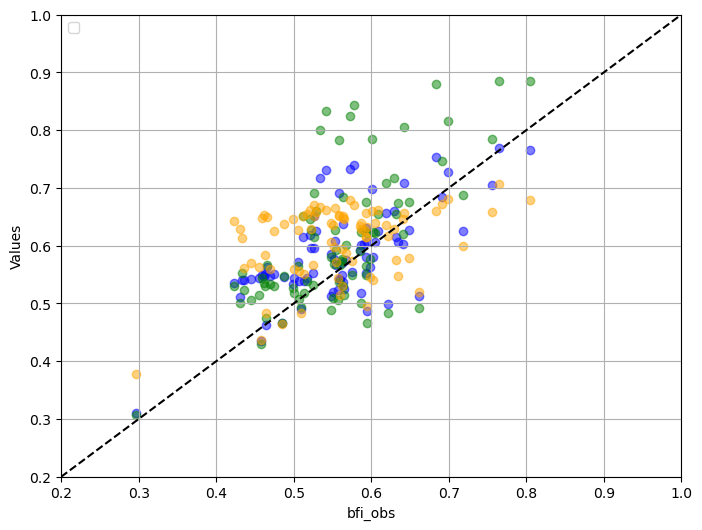

In [266]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_rd1"], color='green', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_wd1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])
